<a href="https://colab.research.google.com/github/dassus98/banking_churn/blob/main/Banking_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
warnings.filterwarnings('ignore')

sns.set_style('dark')
%matplotlib inline

In [3]:
pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiohappyeyeballs                   2.4.6
aiohttp                            3.11.12
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.4
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            7.0.1
astropy-iers-data                  0.2025.2.17.0.34.13
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.1.0
audioread          

# Data Preparation

In [4]:
# Importing dataset as a data frame.

df = pd.read_csv('banking_churn.csv', header=0)
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

Row number and Name are unnecessary. Customer ID should be the index for each sample.

In [5]:
# Dropping the RowNumber and Surname as they are not useful features.
# Setting the index as CustomerId.

df.drop(['RowNumber', 'Surname'], axis=1, inplace=True)
df.set_index('CustomerId', inplace=True)

df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  \
CustomerId                                                          
15634602            619    France  Female   42       2       0.00   
15647311            608     Spain  Female   41       1   83807.86   
15619304            502    France  Female   42       8  159660.80   
15701354            699    France  Female   39       1       0.00   
15737888            850     Spain  Female   43       2  125510.82   

            NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
CustomerId                                                                     
15634602                1          1               1        101348.88       1  
15647311                1          0               1        112542.58       0  
15619304                3          1               0        113931.57       1  
15701354                2          0               0         93826.63       0  
15737888                1          1               1         79084.10       0

In [6]:
# Checking data types.
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Geography and Gender from should be changed from categorical data to numerical data with scikit-learn's label encoding. This will allow the performance of EDA and the use of modelling techniques.

In [7]:
# Encoding categorical features as integers through one-hot-encoding.
label_encoder = preprocessing.LabelEncoder()

df['Geography'] = label_encoder.fit_transform(df['Geography'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])

df.dtypes

CreditScore          int64
Geography            int64
Gender               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
df.head()

CreditScore  Geography  Gender  Age  Tenure    Balance  \
CustomerId                                                           
15634602            619          0       0   42       2       0.00   
15647311            608          2       0   41       1   83807.86   
15619304            502          0       0   42       8  159660.80   
15701354            699          0       0   39       1       0.00   
15737888            850          2       0   43       2  125510.82   

            NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
CustomerId                                                                     
15634602                1          1               1        101348.88       1  
15647311                1          0               1        112542.58       0  
15619304                3          1               0        113931.57       1  
15701354                2          0               0         93826.63       0  
15737888                1          1               1         79084.10       0

In [9]:
# Checking means, max/min values, standard deviations, quantile spreads.
df.describe().transpose()

count           mean           std     min       25%  \
CreditScore      10000.0     650.528800     96.653299  350.00    584.00   
Geography        10000.0       0.746300      0.827529    0.00      0.00   
Gender           10000.0       0.545700      0.497932    0.00      0.00   
Age              10000.0      38.921800     10.487806   18.00     32.00   
Tenure           10000.0       5.012800      2.892174    0.00      3.00   
Balance          10000.0   76485.889288  62397.405202    0.00      0.00   
NumOfProducts    10000.0       1.530200      0.581654    1.00      1.00   
HasCrCard        10000.0       0.705500      0.455840    0.00      0.00   
IsActiveMember   10000.0       0.515100      0.499797    0.00      0.00   
EstimatedSalary  10000.0  100090.239881  57510.492818   11.58  51002.11   
Exited           10000.0       0.203700      0.402769    0.00      0.00   

                        50%          75%        max  
CreditScore         652.000     718.0000     850.00  
Geography             0.000       1.0000       2.00  
Gender                1.000       1.0000       1.00  
Age                  37.000      44.0000      92.00  
Tenure                5.000       7.0000      10.00  
Balance           97198.540  127644.2400  250898.09  
NumOfProducts         1.000       2.0000       4.00  
HasCrCard             1.000       1.0000       1.00  
IsActiveMember        1.000       1.0000       1.00  
EstimatedSalary  100193.915  149388.2475  199992.48  
Exited                0.000       0.0000       1.00

In [10]:
# Checking stratification of dataset. Roughly 20% of the customers have churned.
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [11]:
# Counting duplicates.
df.duplicated().sum()

0

In [12]:
# Counting null values.
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [13]:
# Separating features from dependent variable.
X = df.drop('Exited', axis=1)
y = df['Exited']

X.head()

CreditScore  Geography  Gender  Age  Tenure    Balance  \
CustomerId                                                           
15634602            619          0       0   42       2       0.00   
15647311            608          2       0   41       1   83807.86   
15619304            502          0       0   42       8  159660.80   
15701354            699          0       0   39       1       0.00   
15737888            850          2       0   43       2  125510.82   

            NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
CustomerId                                                             
15634602                1          1               1        101348.88  
15647311                1          0               1        112542.58  
15619304                3          1               0        113931.57  
15701354                2          0               0         93826.63  
15737888                1          1               1         79084.10

In [14]:
print(X.shape)
print(y.shape)

(10000, 10)
(10000,)


# Exploratory Data Analysis

## Color Palette

In [ ]:
# Setting a default colour palette.
sequential_colors = sns.color_palette("Purples", 10)
sequential_colors

[(0.951449442522107, 0.9446981930026913, 0.969519415609381),
 (0.9007612456747405, 0.8963936947327951, 0.9434063821607074),
 (0.8355247981545559, 0.8361707035755478, 0.9118800461361014),
 (0.7469434832756633, 0.7505420991926183, 0.8675893886966551),
 (0.6620530565167244, 0.653440984236832, 0.8126105344098424),
 (0.5771626297577854, 0.5628911956939638, 0.7645059592464436),
 (0.4948558246828143, 0.47598615916955017, 0.7219838523644752),
 (0.4298961937716263, 0.3460668973471741, 0.6540715109573241),
 (0.36764321414840445, 0.22592848904267587, 0.5955401768550557),
 (0.30648212226066895, 0.11035755478662054, 0.5411303344867359)]

## Univariate Analysis

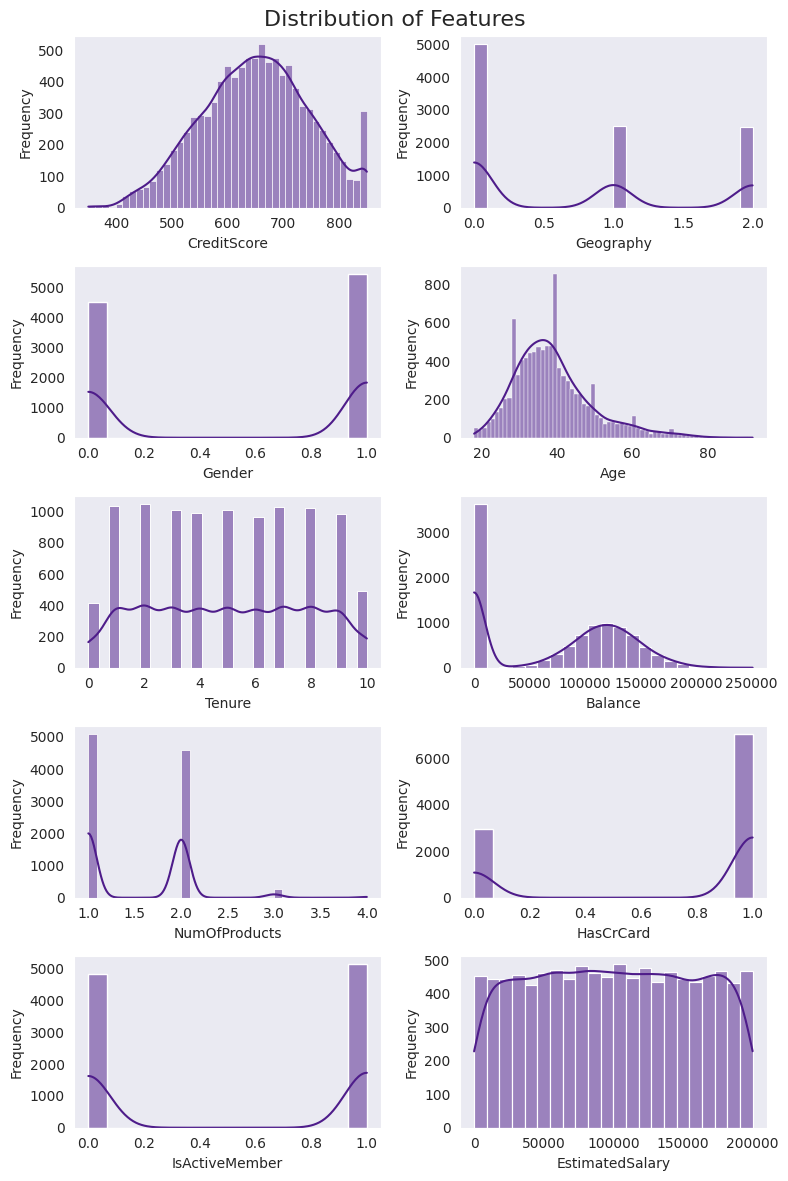

In [ ]:
# Plotting distributions of each feature through histograms.
fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=5)

for i in range(len(X.columns)):
    sns.histplot(X[X.columns[i]], kde=True, ax=axes.flatten()[i], color=sequential_colors[9])
    axes.flatten()[i].set_xlabel(X.columns[i])
    axes.flatten()[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Features', fontsize=16)
plt.tight_layout()

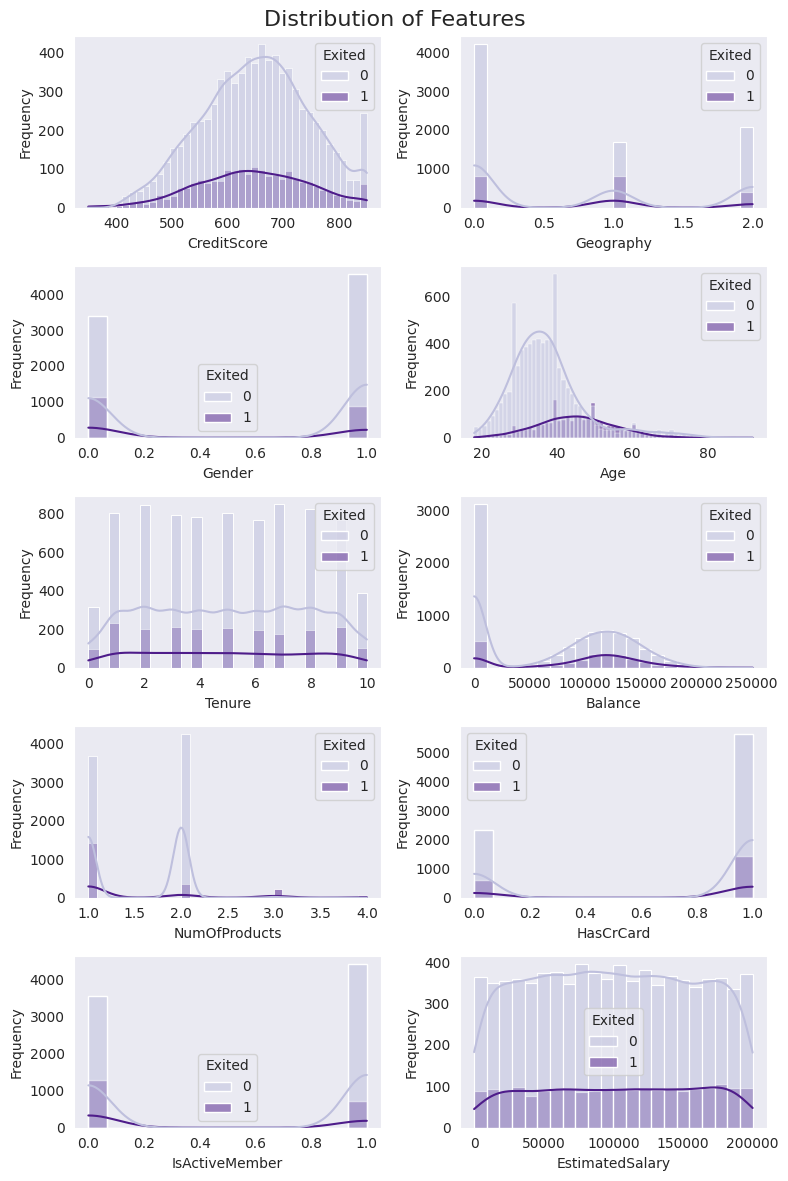

In [ ]:
# Plotting relation of each features to churn through hued histograms.
fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=5)

for i in range(len(X.columns)):
    sns.histplot(data=df, x=df[df.columns[i]], kde=True, ax=axes.flatten()[i], \
                 hue='Exited', palette=[sequential_colors[3], sequential_colors[9]])
    axes.flatten()[i].set_xlabel(X.columns[i])
    axes.flatten()[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Features', fontsize=16)
plt.tight_layout()

### Comments on Distribution of Features

Three continuous features follow a relatively Gaussian distribution: CreditScore, Age and Balance. Balance shows that a substantial amount of customers have zero balance in their account. ExtimatedSalary and Tenure are also continuous variables but with little resemblance to a Gaussian distribution.

Three features are binary and two of them are imbalanced: there are more men than women for Gender and more people have a credit card than not (HasCrCard). IsActiveMember is the only binary feature which is relatively balanced.

NumOfProducts is the only ordinal feature, Geography the only categorical.


### Comments on Distribution and Churn

Five features show no discernable difference in distribution when partitioned for churn: CreditScore, Tenure, Balance, HasCrCard and EstimatedSalary.

Of the remaining five features:
- Geography: Germany seems to be much more likely to churn than France or Spain
- Gender: Women outnumber men for churning customers (opposite of total distribution).
- Age: The age distribution for churning customers shifts to the right - churning customers tend to be older on average.
- NumOfProducts: Customers with only one product seem to be more likely to churn than customers with 2 products.
- IsActiveMember: Inactive members are more likely to churn than active members.

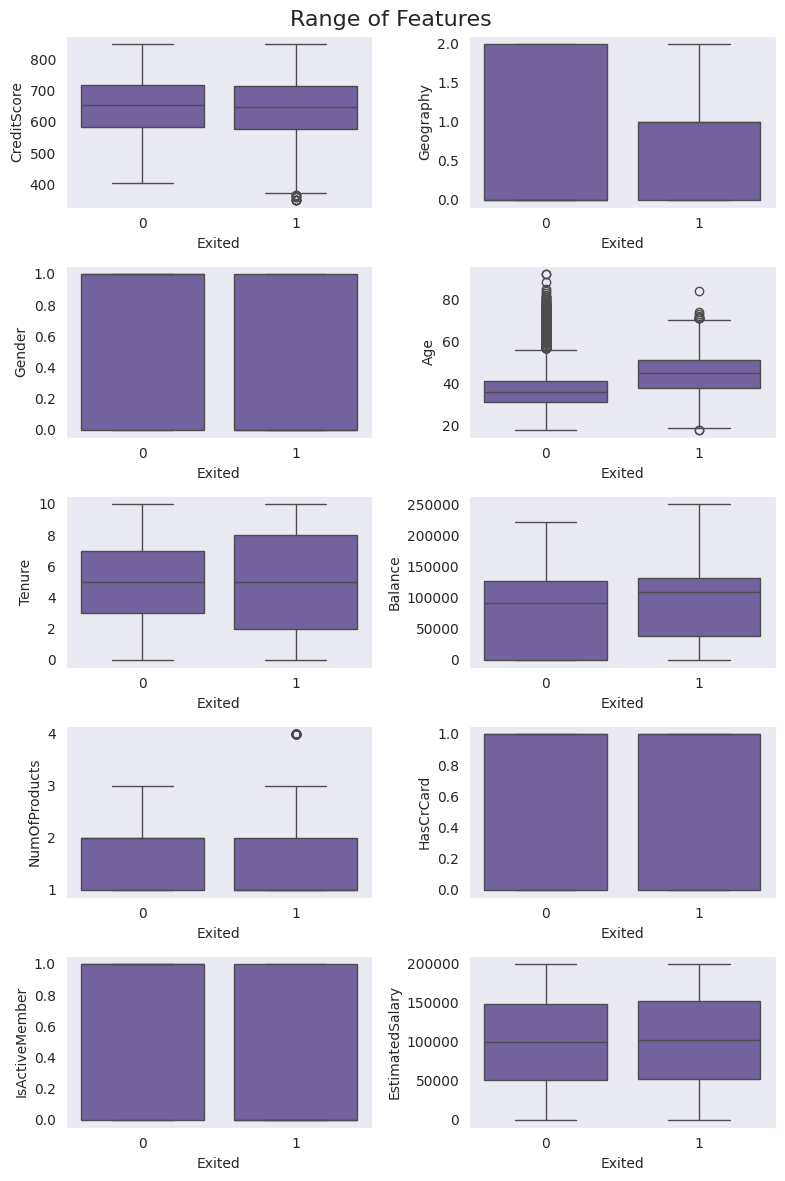

In [ ]:
# Plotting ranges of each feature through boxplots.
fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=5)

for i in range(len(X.columns)):
    sns.boxplot(x='Exited', y=X.columns[i], data=df, ax=axes.flatten()[i], color=sequential_colors[7])

plt.suptitle('Range of Features', fontsize=16)
plt.tight_layout()

### Comments on Distributions and Ranges

There is nothing particularly useful gained from observing the ranges of the features. One fact which is reinforced however is that churning customers then to be older than those retained.

## Correlation Matrix & Bivariate Analysis

<Axes: >

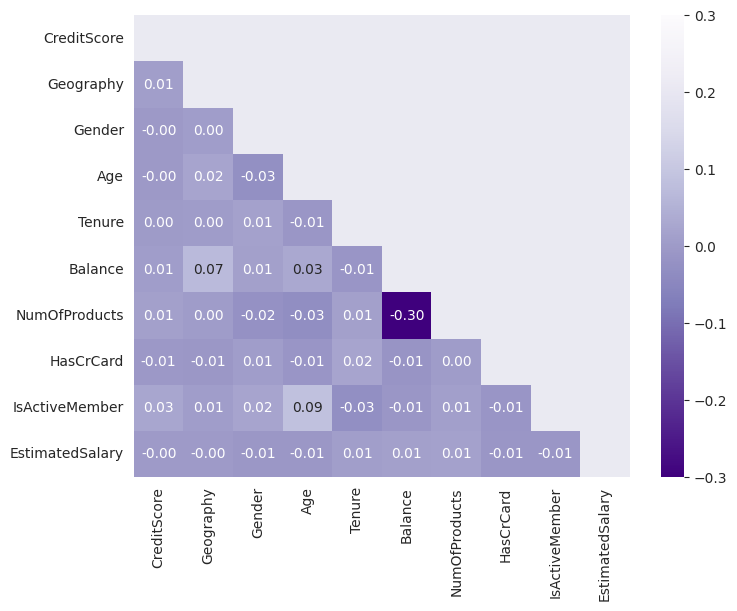

In [ ]:
# Basic correlation matrix of the features.
fig = plt.figure(figsize=(8, 6))

mask = np.triu(np.ones_like(X.corr(), dtype=bool))
sns.heatmap(X.corr(), mask=mask, vmin=-0.3, vmax=0.3, annot=True, fmt='.2f', cmap='Purples_r')

Features are quite independent of one another. Only two features to have a notable covariance are NumOfProducts and Balance. This is surprising because one would normally expect the two features to have a positive relationship: customers who use multiple products have higher balances.

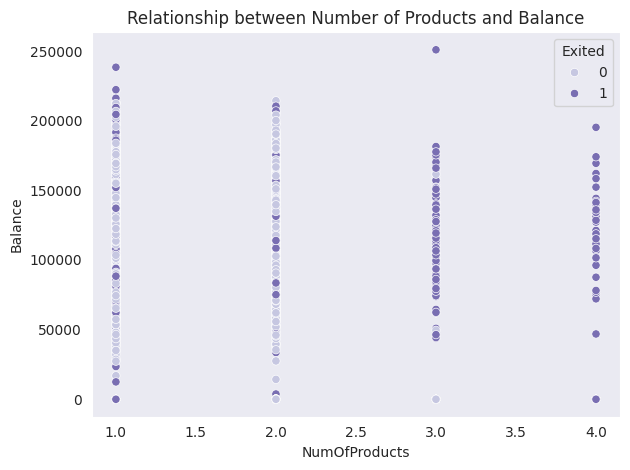

In [ ]:
# Plotting relationship between NumOfProducts and Balance.
sns.scatterplot(x='NumOfProducts', y='Balance', data=df, hue='Exited', palette='Purples')

plt.title('Relationship between Number of Products and Balance')
plt.tight_layout()

### Comments on Bivariate Relationship

One can see the relationship more clearly here. As the NumOfProducts increases, the range of the Balance shrinks towards the center. It also appears that a higher NumOfProducts is far more likely to be correlated with churn. Having a high Balance doesn't seem to place a customer at risk of churn so long as they are using fewer products.

# Supervised Modelling with Decision Trees & Random Forests

## Functions / Utilities

In [15]:
def model_metrics(model, X_train, y_train, X_val, y_val):
  print(f'Training Accuracy: {model.score(X_train, y_train):.3f}')
  print(f'Validation Accuracy: {model.score(X_val, y_val):.3f}')
  print(f'ROC-AUC: {roc_auc_score(y_val, model.predict(X_val)):.3f}')
  print(f'Recall: {recall_score(y_val, model.predict(X_val)):.3f}')
  print('\n-----\n')
  print(classification_report(y_val, model.predict(X_val)))
  print('\n-----\n')

In [16]:
def model_metrics_with_changes(base_model, final_model, X_train, y_train, X_val, y_val):
  print('Change from Base Model')
  print('\n-----\n')
  print(f'Training Accuracy: {final_model.score(X_train, y_train) - base_model.score(X_train, y_train):.3f}')
  print(f'Validation Accuracy: {final_model.score(X_val, y_val) - base_model.score(X_val, y_val):.3f}')
  print(f'ROC AUC: {roc_auc_score(y_val, final_model.predict(X_val)) - roc_auc_score(y_val, base_model.predict(X_val)):.3f}')
  print(f'Precision: {precision_score(y_val, final_model.predict(X_val)) - precision_score(y_val, base_model.predict(X_val)):.3f}')
  print(f'Recall: {recall_score(y_val, final_model.predict(X_val)) - recall_score(y_val, base_model.predict(X_val)):.3f}')
  print('\n-----\n')
  print(confusion_matrix(y_val, final_model.predict(X_val)) - confusion_matrix(y_val, base_model.predict(X_val)))
  print('\n-----\n')

In [17]:
def plot_accuracy_recall(param_list, accuracy_list, recall_list, title, xlabel):

  # Finding the maximum value for validation accuracy and ROC-AUC.
  max_accuracy_index = np.argmax(accuracy_list)
  max_recall_index = np.argmax(recall_list)

  # Plotting the figure.
  plt.plot(param_list, accuracy_list)
  plt.plot(param_list, recall_list)
  plt.legend(['Accuracy', 'Recall'])
  plt.xlabel(xlabel)
  plt.ylabel('Score')
  plt.xlim(min(param_list), max(param_list))
  plt.ylim(0.25, 1)
  plt.vlines(param_list[max_accuracy_index], 0.25, 1, color='steelblue', linestyles='dashed')
  plt.vlines(param_list[max_recall_index], 0.25, 1, color='orange', linestyles='dashed')
  plt.title(title)
  plt.show()

In [18]:
# Creating a dictionary with keys 0-9 and header values as values.
header_dict = {}
for i in range(10):
    if i < len(df.columns):
        header_dict[i] = df.columns[i]
    else:
        header_dict[i] = None

header_dict

{0: 'CreditScore',
 1: 'Geography',
 2: 'Gender',
 3: 'Age',
 4: 'Tenure',
 5: 'Balance',
 6: 'NumOfProducts',
 7: 'HasCrCard',
 8: 'IsActiveMember',
 9: 'EstimatedSalary'}

In [19]:
def plot_feature_importances(model, header_dict, title):

  # Obtaining feature importances and sorting them.
  feature_importances = model.feature_importances_
  sorted_indices = np.argsort(feature_importances)[::-1]
  sorted_importances = feature_importances[sorted_indices]

  # Preparing x-axis labels using header_dict.
  x_labels = [header_dict.get(i) for i in sorted_indices if header_dict.get(i) is not None]

  # Plotting the figure.
  plt.figure(figsize=(10, 6))
  plt.bar(range(len(sorted_importances)), sorted_importances)
  plt.xticks(range(len(sorted_importances)), x_labels, rotation=45, ha='right')
  plt.xlabel("Features")
  plt.ylabel("Importance")
  plt.title(f"Feature Importances from {str(title)}")
  plt.tight_layout()

In [20]:
def plot_confusion_matrix(y_true, y_pred, title):

  # Generating the confusion matrix.
  cm = confusion_matrix(y_val, y_pred)

  # Plotting the figure.
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'])
  plt.title(f'Confusion Matrix for {title}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

## Preprocessing

In [21]:
# Scaling the values to a range of [0, 1] such that gradient optimization can be smoother for neural networks.

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [22]:
print(X[:5])

[[0.538      0.         0.         0.32432432 0.2        0.
  0.         1.         1.         0.50673489]
 [0.516      1.         0.         0.31081081 0.1        0.33403148
  0.         0.         1.         0.56270874]
 [0.304      0.         0.         0.32432432 0.8        0.63635718
  0.66666667 1.         0.         0.56965435]
 [0.698      0.         0.         0.28378378 0.1        0.
  0.33333333 0.         0.         0.46912005]
 [1.         1.         0.         0.33783784 0.2        0.50024622
  0.         1.         1.         0.39540036]]


In [23]:
print(X.shape)
print(y.shape)

(10000, 10)
(10000,)


In [24]:
# Splitting the data off into train/val/test splits of 80/10/10.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, stratify=y_train, random_state=123)

In [25]:
# Checking shapes.

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 10)
(8000,)
(1000, 10)
(1000,)
(1000, 10)
(1000,)


In [26]:
# Checking stratification to ensure that we have similar proportions of churn in each set.

print(y_train.value_counts() / len(y_train))
print(y_val.value_counts() / len(y_val))
print(y_test.value_counts() / len(y_test))

Exited
0    0.796375
1    0.203625
Name: count, dtype: float64
Exited
0    0.796
1    0.204
Name: count, dtype: float64
Exited
0    0.796
1    0.204
Name: count, dtype: float64


## Decision Tree Classifier

Decision Trees are a standard classification method which can be used as a base model going forward. The model ought to fit this data quite well as it is a straightforward binary classification problem with only ten features.

Let's explore the Decision Tree Classifier along with the tuning of its hyperparameters.

### Base Decision Tree Model

In [ ]:
# Building a base model.
base_tree = DecisionTreeClassifier(random_state=123)
base_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [ ]:
# Predicting values and observing scoring metrics.
base_tree_pred = base_tree.predict(X_val)

model_metrics(base_tree, X_train, y_train, X_val, y_val)
print(f'Depth: {base_tree.get_depth()}')
print(f'Number of Leaves: {base_tree.get_n_leaves()}')
print(f'Number of Features: {base_tree.n_features_in_}')

Training Accuracy: 1.000
Validation Accuracy: 0.791
ROC-AUC: 0.696
Recall: 0.534

-----

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       796
           1       0.49      0.53      0.51       204

    accuracy                           0.79      1000
   macro avg       0.68      0.70      0.69      1000
weighted avg       0.80      0.79      0.79      1000


-----

Depth: 26
Number of Leaves: 1150
Number of Features: 10


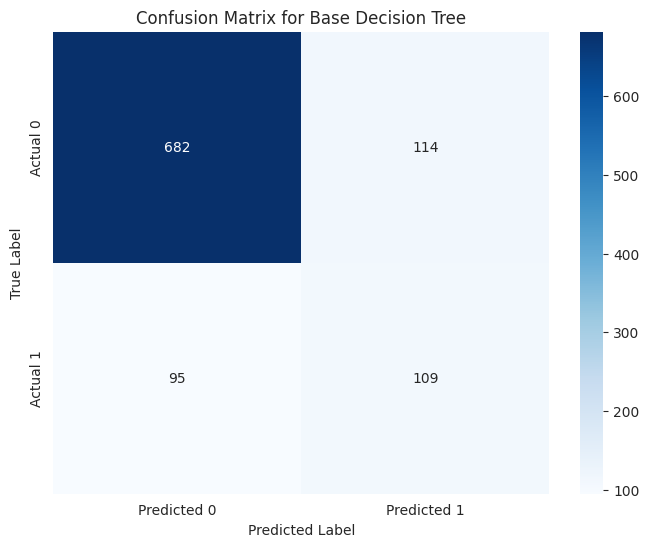

In [ ]:
# Plotting a confusion matrix.
plot_confusion_matrix(y_val, base_tree_pred, 'Base Decision Tree')

In [ ]:
# Retrieving parameters of base model.
base_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 123,
 'splitter': 'best'}

In [ ]:
# Retrieving feature importances of base model.
base_tree.feature_importances_

array([0.14891093, 0.03267179, 0.01583985, 0.22706832, 0.08445266,
       0.15529819, 0.11707753, 0.01027169, 0.05198732, 0.15642173])

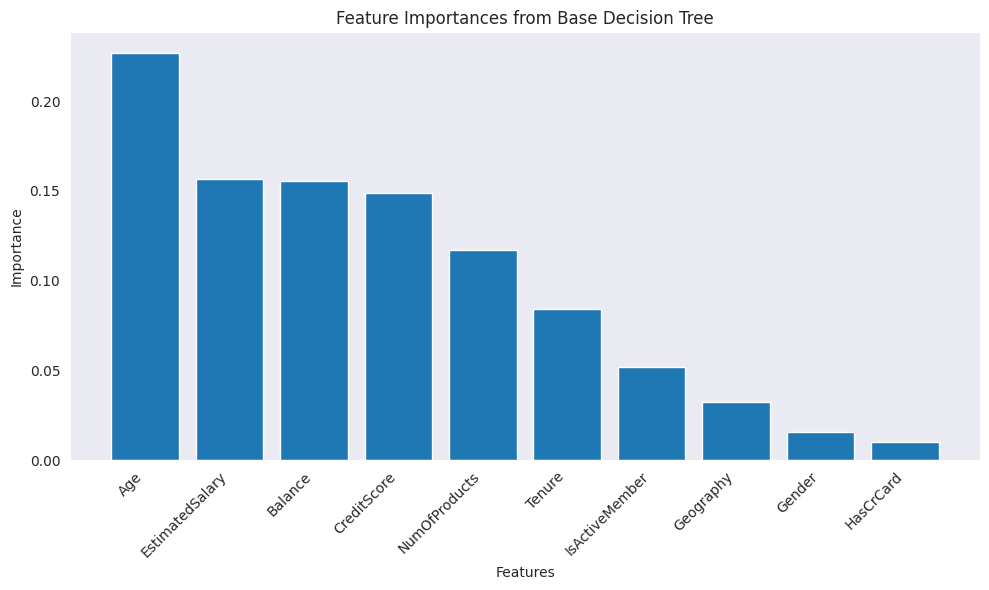

In [ ]:
# Plotting feature importances.
plot_feature_importances(base_tree, header_dict, 'Base Decision Tree')

### Comments

We can see that the base Decision Tree model provides some importance to all the features, albeit Geography, Gender and HasCrCard are nearly zero. The base validation accuracy of 0.791 is not bad either but the tree has absolutely overfit with a training accuracy of 1.000.

The F1-Score is 0.51. Both the precision and recall scores for churning customers are quite poor. The base model is unable to accurately distinguish the churned customers and is likely to miss them altogether as false negatives (recall = 0.53). The value for precision of churned customers is also a paltry 0.49.

It might be wiser to aim for a high recall rather than a high precision. Since we are trying to minimize churn, it will likely be done through reaching out and offering better deals to at-risk customers. It is best to cast a large net and focus on reducing false negatives (i.e. higher recall) than worry about false positives. Customers who are *not* at-risk of churn certainly won't mind receiving an extra call or email for a new product offering. But those who are already considering leaving the bank will not be stopped unless convinced that remaining with this current bank is in their best interests.

We will see below if hyperparameter tuning is able to relieve some of these issues. Hyperparameters will be charted with jagged lines identifying the maximum point of validation score and recall. These graphs will then be used to identify a range of values which will be sifted through with a Randomized Search and a Bayesian Search.

### Hyperparameter Tuning

In [ ]:
# Observing metrics by criterion.
criterion_list = ['gini', 'entropy']

for criterion in criterion_list:
    tree = DecisionTreeClassifier(criterion=criterion, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    print(f'Criterion: {criterion}')
    print('-----')
    print(f'Accuracy: {accuracy_score(y_val, tree_pred):.3f}')
    print(f'Recall: {recall_score(y_val, tree_pred):.3f}')
    print('-----')
    print(classification_report(y_val, tree_pred))
    print('-----')
    print(confusion_matrix(y_val, tree_pred))
    print('-----')

Criterion: gini
-----
Accuracy: 0.791
Recall: 0.534
-----
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       796
           1       0.49      0.53      0.51       204

    accuracy                           0.79      1000
   macro avg       0.68      0.70      0.69      1000
weighted avg       0.80      0.79      0.79      1000

-----
[[682 114]
 [ 95 109]]
-----
Criterion: entropy
-----
Accuracy: 0.788
Recall: 0.520
-----
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       796
           1       0.48      0.52      0.50       204

    accuracy                           0.79      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.79      0.79      0.79      1000

-----
[[682 114]
 [ 98 106]]
-----


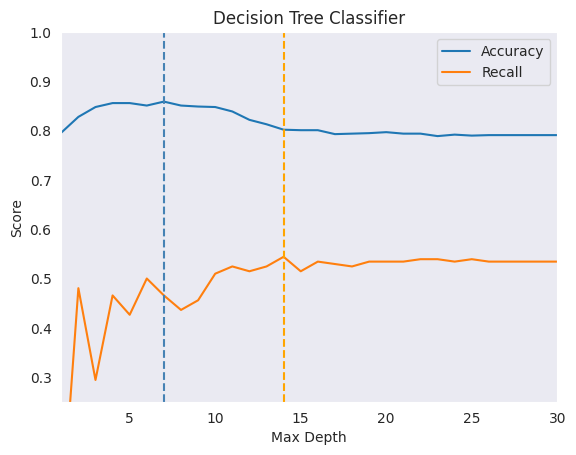

In [ ]:
# Observing metrics by max_depth.
max_depth_list = np.arange(1, 31)
accuracy_list = []
recall_list = []

for max_depth in max_depth_list:
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(max_depth_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Max Depth')

In [ ]:
# Observing metrics by max_features.
max_features_list = ['sqrt', 'log2', None]
accuracy_list = []
recall_list = []

for max_features in max_features_list:
    tree = DecisionTreeClassifier(max_features=max_features, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))
    print(f'Max Features: {max_features}')
    print(f'Number of Features: {tree.max_features_}')
    print('-----')
    print(f'Accuracy: {accuracy_score(y_val, tree_pred):.3f}')
    print(f'ROC AUC: {recall_score(y_val, tree_pred):.3f}')
    print('-----')
    print(classification_report(y_val, tree_pred))
    print('-----')
    print(confusion_matrix(y_val, tree_pred))
    print('-----')

Max Features: sqrt
Number of Features: 3
-----
Accuracy: 0.776
ROC AUC: 0.505
-----
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       796
           1       0.46      0.50      0.48       204

    accuracy                           0.78      1000
   macro avg       0.66      0.68      0.67      1000
weighted avg       0.79      0.78      0.78      1000

-----
[[673 123]
 [101 103]]
-----
Max Features: log2
Number of Features: 3
-----
Accuracy: 0.776
ROC AUC: 0.505
-----
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       796
           1       0.46      0.50      0.48       204

    accuracy                           0.78      1000
   macro avg       0.66      0.68      0.67      1000
weighted avg       0.79      0.78      0.78      1000

-----
[[673 123]
 [101 103]]
-----
Max Features: None
Number of Features: 10
-----
Accuracy: 0.791
ROC AUC: 0.534
-----
              precision

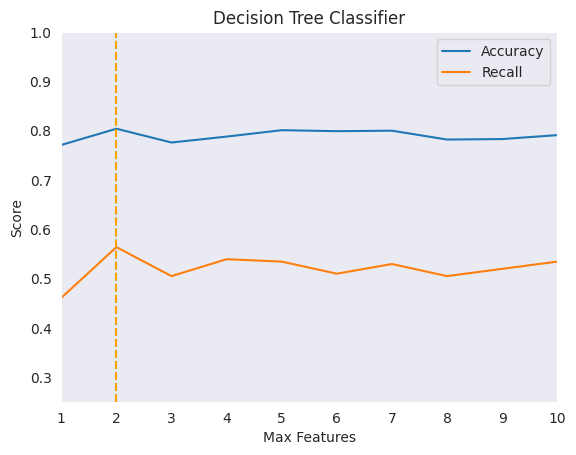

In [ ]:
# Observing metrics by max_features.
max_features_list = np.arange(1, 11)
accuracy_list = []
recall_list = []

for max_features in max_features_list:
    tree = DecisionTreeClassifier(max_features=max_features, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(max_features_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Max Features')

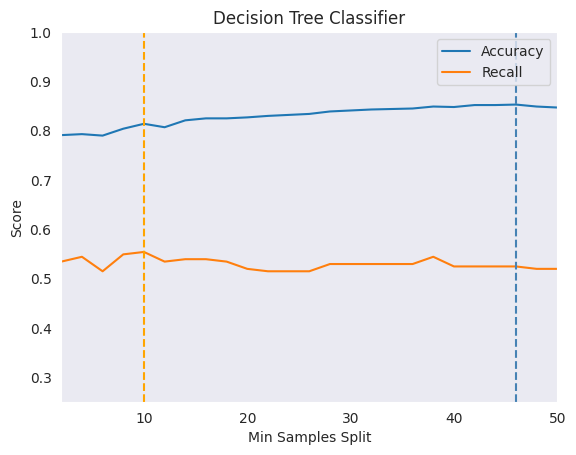

In [ ]:
# Observing metrics by min_samples_split.
min_samples_split_list = np.arange(2, 51, 2)
accuracy_list = []
recall_list = []

for min_samples_split in min_samples_split_list:
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(min_samples_split_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Min Samples Split')

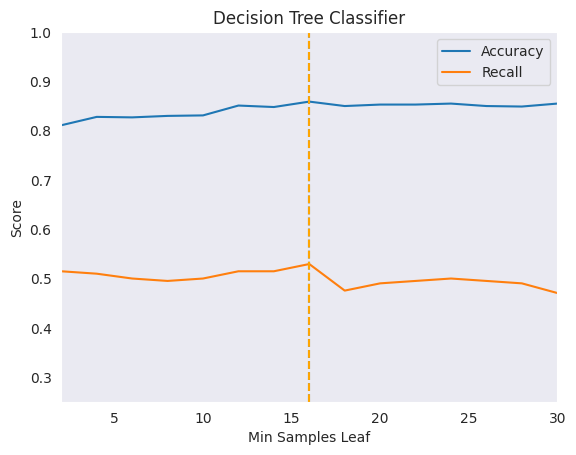

In [ ]:
# Observing metrics by min_samples_leaf.
min_samples_leaf_list = np.arange(2, 31, 2)
accuracy_list = []
recall_list = []

for min_samples_leaf in min_samples_leaf_list:
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(min_samples_leaf_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Min Samples Leaf')

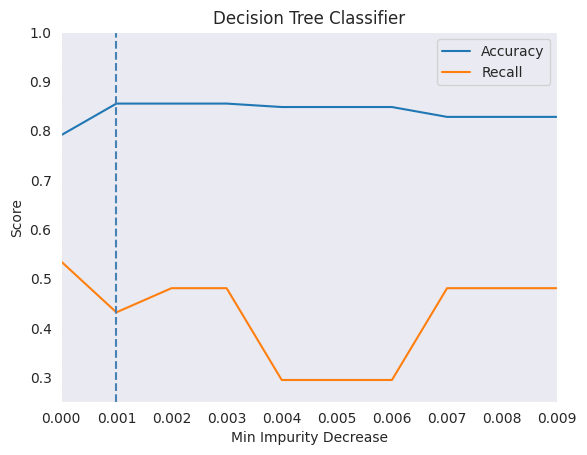

In [ ]:
# Observing metrics by min_impurity_decrease.
min_impurity_decrease_list = np.arange(0, 0.01, 0.001)
accuracy_list = []
recall_list = []

for min_impurity_decrease in min_impurity_decrease_list:
    tree = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))


plot_accuracy_recall(min_impurity_decrease_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Min Impurity Decrease')

### Randomized & Bayesian Search

Here we will experiment with a Randomized Search and a Bayesian Search. Both methods will be used in order to explore improvements in efficiency of hyperparameter tuning. We'll choose the range of values based on the previous graphs, which highlight for us the values where validation accuracies and ROC-AUC scores are the highest.

In [ ]:
# Since neither the validation score nor the recall particularly changed across the hyperparameters,
# we will be casting a broad net with the RandomizedSearch parameter grid.

from sklearn.model_selection import RandomizedSearchCV

criterion_list = ['gini', 'entropy']
max_depth_list = np.arange(5, 16)
max_features_list = np.arange(1, 11)
min_samples_leaf_list = np.arange(5, 31, 5)
min_samples_split_list = np.arange(5, 51, 5)
min_impurity_decrease_list = np.arange(0, 0.01, 0.001)

tree_param_grid = {'criterion': criterion_list,
              'max_depth': max_depth_list,
              'max_features': max_features_list,
              'min_samples_leaf': min_samples_leaf_list,
              'min_samples_split': min_samples_split_list,
              'min_impurity_decrease': min_impurity_decrease_list}

In [ ]:
# Finding the optimal model with randomized search.
%%time

randomized_tree = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(randomized_tree, tree_param_grid, scoring='recall', \
                                   n_iter = 500, cv = 5, random_state=123)
random_search.fit(X_train, y_train)

CPU times: user 34.8 s, sys: 62.8 ms, total: 34.8 s
Wall time: 35.9 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=500,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009]),
                                        'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30]),
                                        'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])},
                   random_state=123, scoring='recall')

In [ ]:
# Printing score and parameter values for the optimal model.
print(random_search.best_score_)
print(random_search.best_params_)

0.4769853704577631
{'min_samples_split': 5, 'min_samples_leaf': 15, 'min_impurity_decrease': 0.0, 'max_features': 10, 'max_depth': 11, 'criterion': 'gini'}


In [ ]:
# Finding the optimal model with Bayesian Search.
%%time

from skopt import BayesSearchCV

opt = BayesSearchCV(DecisionTreeClassifier(), tree_param_grid, scoring='recall', \
                    n_iter=100, cv=5, random_state=123)
opt.fit(X_train, y_train)

CPU times: user 24min 20s, sys: 2min 42s, total: 27min 3s
Wall time: 17min 32s


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
              random_state=123, scoring='recall',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                             'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                             'min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009]),
                             'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30]),
                             'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])})

In [ ]:
# Printing the score and parameter values of the optimal model.
print(opt.best_score_)
print(opt.best_params_)

0.4990825861255309
OrderedDict([('criterion', 'entropy'), ('max_depth', 11), ('max_features', 7), ('min_impurity_decrease', 0.0), ('min_samples_leaf', 15), ('min_samples_split', 5)])


Bayesian Search returns a marginally better score for the Decision Tree Classifier.

### Final Decision Tree Model

In [ ]:
# Creating the final tree model.
final_tree = DecisionTreeClassifier(criterion='entropy', max_depth=11, max_features=7, \
                                    min_impurity_decrease=0.0, min_samples_leaf=15, \
                                    min_samples_split=5, random_state=123)
final_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=11, max_features=7,
                       min_samples_leaf=15, min_samples_split=5,
                       random_state=123)

In [ ]:
# Observing metrics for the final model.
final_tree_pred = final_tree.predict(X_val)

model_metrics(final_tree, X_train, y_train, X_val, y_val)
print(f'Depth: {final_tree.get_depth()}')
print(f'Number of Leaves: {final_tree.get_n_leaves()}')
print(f'Number of Features: {final_tree.n_features_in_}')

Training Accuracy: 0.876
Validation Accuracy: 0.851
ROC-AUC: 0.715
Recall: 0.485

-----

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       796
           1       0.69      0.49      0.57       204

    accuracy                           0.85      1000
   macro avg       0.78      0.72      0.74      1000
weighted avg       0.84      0.85      0.84      1000


-----

Depth: 11
Number of Leaves: 255
Number of Features: 10


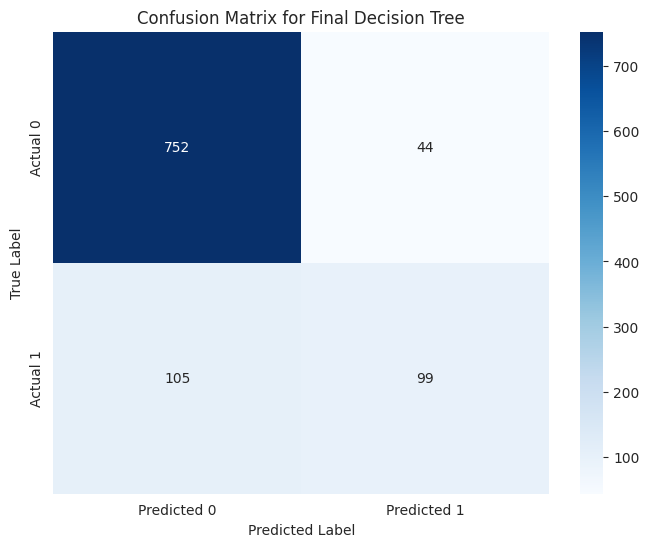

In [ ]:
# Plotting confusion matrix.
plot_confusion_matrix(y_val, final_tree_pred, 'Final Decision Tree')

In [ ]:
# Observing feature importances.
final_tree.feature_importances_

array([0.05280954, 0.05053236, 0.02611537, 0.33058518, 0.02413866,
       0.12252683, 0.25628899, 0.00385143, 0.07436382, 0.05878781])

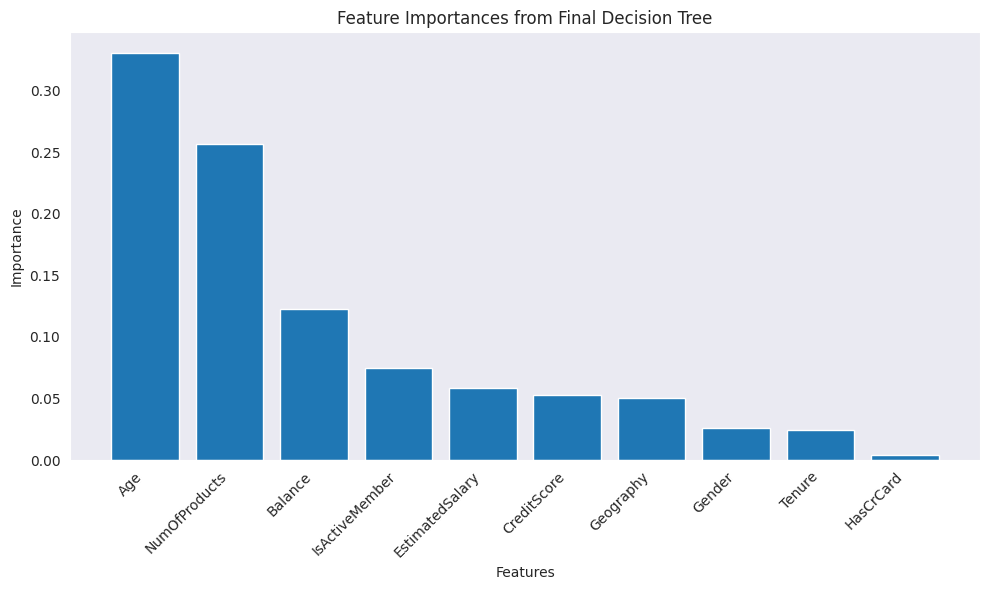

In [ ]:
# Plotting feature importances.
plot_feature_importances(final_tree, header_dict, 'Final Decision Tree')

In [ ]:
# Observing changes in metrics.
model_metrics_with_changes(base_tree, final_tree, X_train, y_train, X_val, y_val)
print(f'Depth: {final_tree.get_depth() - base_tree.get_depth()}')
print(f'Number of Leaves: {final_tree.get_n_leaves() - base_tree.get_n_leaves()}')
print(f'Number of Features: {final_tree.n_features_in_ - base_tree.n_features_in_}')
print('\n-----\n')
print(f'Feature Importances: {final_tree.feature_importances_ - base_tree.feature_importances_}')

Change from Base Model

-----

Training Accuracy: -0.124
Validation Accuracy: 0.060
ROC AUC: 0.019
Precision: 0.204
Recall: -0.049

-----

[[ 70 -70]
 [ 10 -10]]

-----

Depth: -15
Number of Leaves: -895
Number of Features: 0

-----

Feature Importances: [-0.09610139  0.01786057  0.01027552  0.10351687 -0.06031401 -0.03277136
  0.13921147 -0.00642026  0.0223765  -0.09763392]


Hyperparameter tuning has yielded a substantial decrease in overfitting. Generalization was improved by a value of 0.060 with a reduction in training score by 0.124.

Feature importances have been significantly shifted. The base model placed a relatively equal importance on 5 features (feature importance range of 0.10-0.30). The final model focuses on two features: Age and NumOfProducts. This may open up the potentiality for using PCA to reduce the number of features for neural networks, but that will not be explored at this present moment.

As mentioned earlier, older customers and those with more products are more likely to leave. The decision tree model manages to sustain a recall of 0.485 in its final edition. The recall score is still quite low. It is not clearly understandable why the score is so minimal - it might be possible to increase it through feature engineering which allows for more complex relationships in the data to be captured. It is also possible that this data set is not detailed enough to sustain a high recall. Perhaps some of this can be mitigated by artificially generating new samples of the underrepresented class (churning customers), but one would hope that having a stratification of 20% would be sufficient for a model to discern churning from non-churning customers.

Nevertheless, the final decision tree model does manage to sustain a validation score of 0.851 with a substantial reduction in the training score, so there has been some progress made.


## Random Forest Classifier

The second classification method to be explored will be Random Forests. Random Forests follow a similar method to Decision Trees with two key distinctions: it uses the bootstrap method to choose a random set of samples to build trees and it uses a random subset of max_features to build each tree. These two settings of randomness ought to ensure that Random Forests be less prone to overfitting than Decision Trees. The idea is that the various causes of variance will cancel each other out and the final model will yield an averaged error rate.

Let's see how the Random Forest performs on the data along with the tuning of its hyperparameters.

### Base Random Forest Model

In [ ]:
# Building a base model.
base_forest = RandomForestClassifier(random_state=123)
base_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [ ]:
# Observing metrics for base model.
base_forest_pred = base_forest.predict(X_val)

model_metrics(base_forest, X_train, y_train, X_val, y_val)
print(f'Number of Estimators: {base_forest.n_estimators}')

Training Accuracy: 1.000
Validation Accuracy: 0.854
ROC-AUC: 0.706
Recall: 0.456

-----

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       796
           1       0.73      0.46      0.56       204

    accuracy                           0.85      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.84      0.85      0.84      1000


-----

Number of Estimators: 100


In [ ]:
# Observing parameters.
base_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

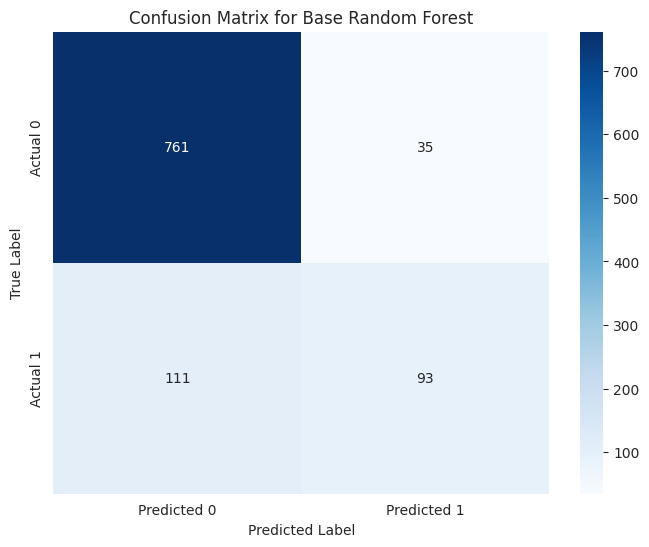

In [ ]:
# Plotting the confusion matrix.
plot_confusion_matrix(y_val, base_forest_pred, 'Base Random Forest')

In [ ]:
# Observing feature importances.
base_forest.feature_importances_

array([0.14352628, 0.03828579, 0.01887484, 0.24084933, 0.08201108,
       0.14338015, 0.12861183, 0.01997988, 0.03909034, 0.14539048])

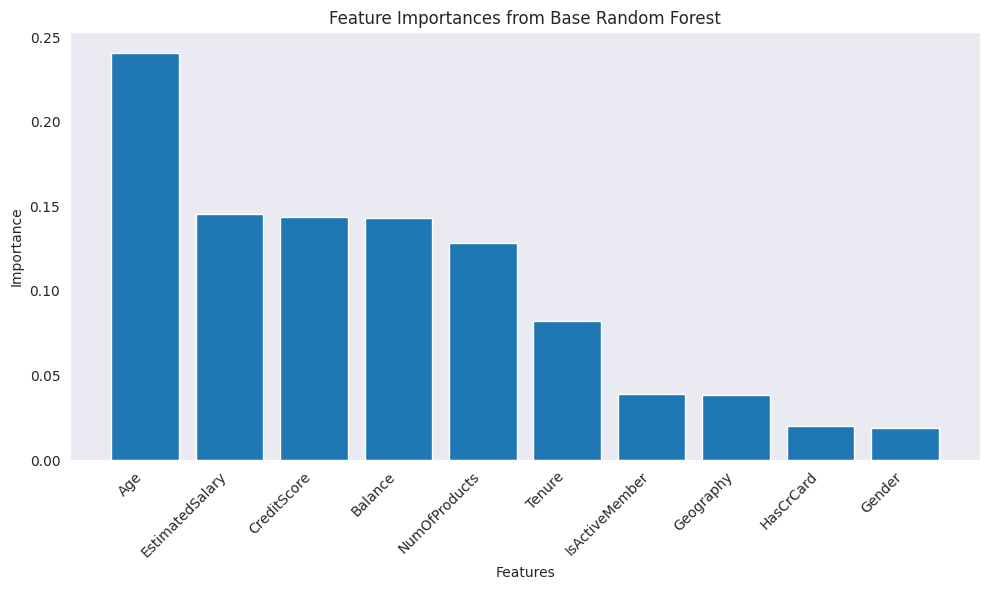

In [ ]:
# Plotting feature importances.
plot_feature_importances(base_forest, header_dict, 'Base Random Forest')

### Comments

The base model overfits absolutely but the validation accuracy is much higher than the base Decision Tree model. Recall score is unfortunately lower.

### Hyperparameter Tuning

In [ ]:
# Observing metrics by criterion.
criterion_list = ['gini', 'entropy']

for criterion in criterion_list:
    forest = RandomForestClassifier(criterion=criterion, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    print(f'Criterion: {criterion}')
    print('-----')
    print(f'Accuracy: {accuracy_score(y_val, forest_pred):.3f}')
    print(f'Recall: {recall_score(y_val, forest_pred):.3f}')
    print('-----')
    print(classification_report(y_val, forest_pred))
    print('-----')
    print(confusion_matrix(y_val, forest_pred))
    print('-----')

Criterion: gini
-----
Accuracy: 0.854
Recall: 0.456
-----
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       796
           1       0.73      0.46      0.56       204

    accuracy                           0.85      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.84      0.85      0.84      1000

-----
[[761  35]
 [111  93]]
-----
Criterion: entropy
-----
Accuracy: 0.859
Recall: 0.451
-----
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       796
           1       0.76      0.45      0.57       204

    accuracy                           0.86      1000
   macro avg       0.82      0.71      0.74      1000
weighted avg       0.85      0.86      0.84      1000

-----
[[767  29]
 [112  92]]
-----


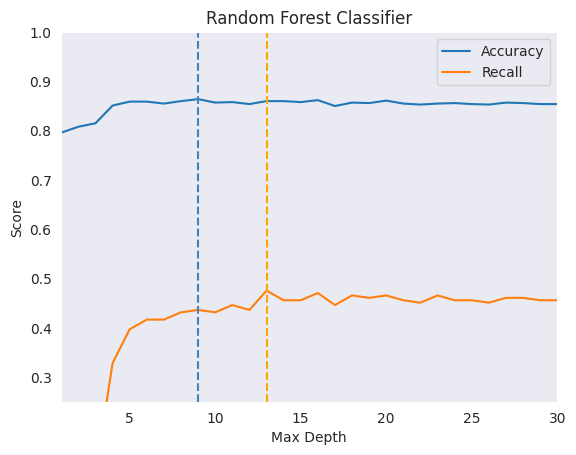

In [ ]:
# Observing metrics by max_depth.
max_depth_list = np.arange(1, 31)
accuracy_list = []
recall_list = []

for max_depth in max_depth_list:
    forest = RandomForestClassifier(max_depth=max_depth, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(max_depth_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Max Depth')

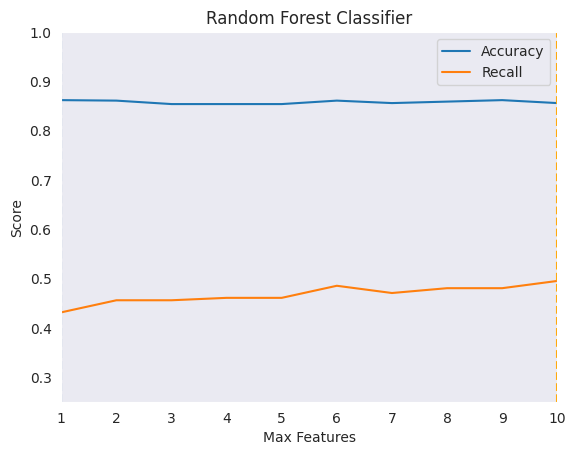

In [ ]:
# Observing metrics by max_features.
max_features_list = np.arange(1, 11)
accuracy_list = []
recall_list = []

for max_features in max_features_list:
    forest = RandomForestClassifier(max_features=max_features, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(max_features_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Max Features')

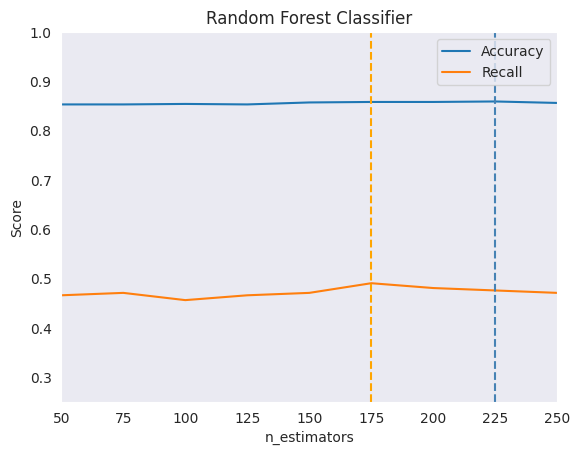

In [ ]:
# Observing metrics by n_estimators.
n_estimators_list = np.arange(50, 251, 25)
accuracy_list = []
recall_list = []

for n_estimators in n_estimators_list:
    forest = RandomForestClassifier(n_estimators=n_estimators, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(n_estimators_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'n_estimators')

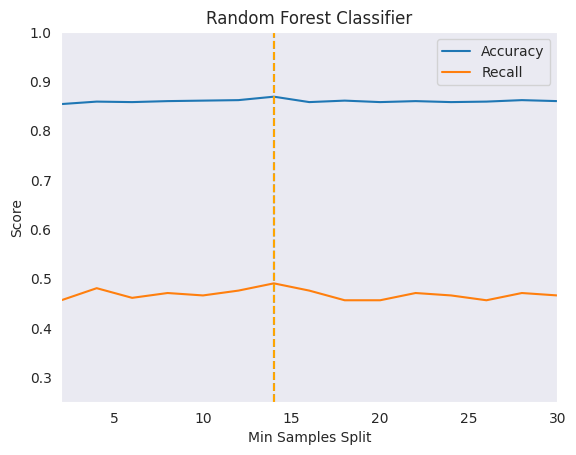

In [ ]:
# Observing metrics by min_samples_split.
min_samples_split_list = np.arange(2, 31, 2)
accuracy_list = []
recall_list = []

for min_samples_split in min_samples_split_list:
    forest = RandomForestClassifier(min_samples_split=min_samples_split, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(min_samples_split_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Min Samples Split')

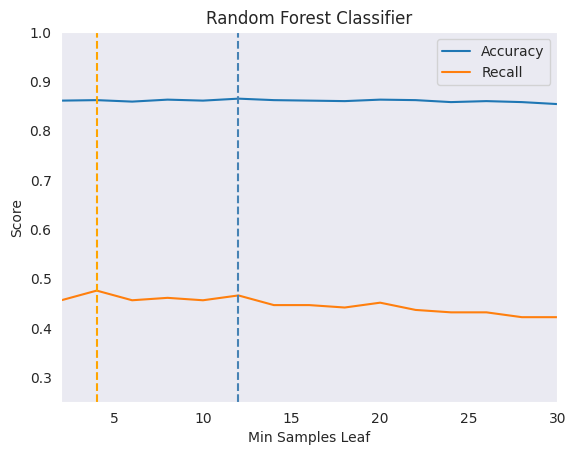

In [ ]:
# Observing metrics by min_samples_leaf.
min_samples_leaf_list = np.arange(2, 31, 2)
accuracy_list = []
recall_list = []

for min_samples_leaf in min_samples_leaf_list:
    forest = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(min_samples_leaf_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Min Samples Leaf')

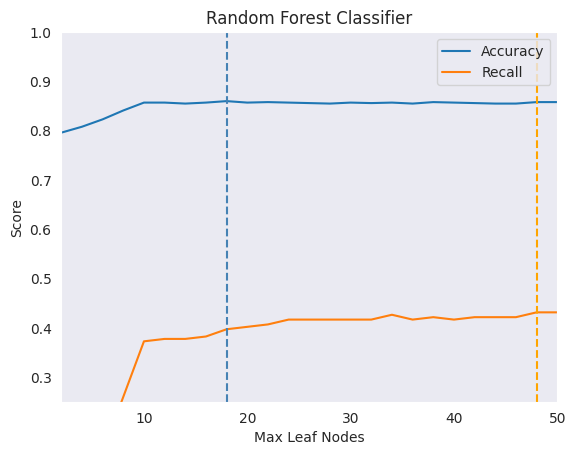

In [ ]:
# Observing metrics by max_leaf_nodes.
max_leaf_nodes_list = np.arange(2, 51, 2)
accuracy_list = []
recall_list = []

for max_leaf_nodes in max_leaf_nodes_list:
    forest = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(max_leaf_nodes_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Max Leaf Nodes')

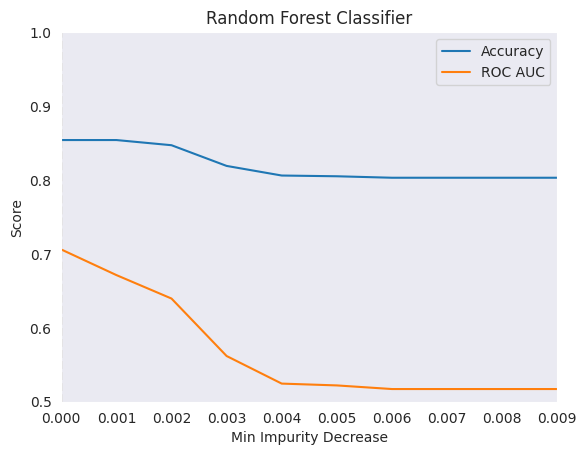

In [ ]:
# Observing metrics by min_impurity_decrease.
min_impurity_decrease_list = np.arange(0.0, 0.01, 0.001)
accuracy_list = []
recall_list = []

for min_impurity_decrease in min_impurity_decrease_list:
    forest = RandomForestClassifier(min_impurity_decrease=min_impurity_decrease, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy_list.append(accuracy_score(y_val, forest_pred))
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(min_impurity_decrease_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Min Impurity Decrease')

### Randomized & Bayesian Search

In [ ]:
# Establishing a parameter grid.
from sklearn.model_selection import RandomizedSearchCV

criterion_list = ['gini', 'entropy']
max_depth_list = list(np.arange(10, 31, 2)) + [None]
max_features_list = list(np.arange(1, 11)) + ['sqrt', 'log2']
n_estimators_list = list(np.arange(50, 251, 25))
min_samples_split_list = list(np.arange(2, 31, 2))
min_samples_leaf_list = list(np.arange(2, 31, 2))
max_leaf_nodes_list = list(np.arange(10, 51, 5)) + [None]

forest_param_grid = {'criterion': criterion_list,
              'max_depth': max_depth_list,
              'max_features': max_features_list,
              'n_estimators': n_estimators_list,
              'min_samples_split': min_samples_split_list,
              'min_samples_leaf': min_samples_leaf_list,
              'max_leaf_nodes': max_leaf_nodes_list}

In [ ]:
# Optimizing model with RandomizedSearch.
%%time

random_search = RandomizedSearchCV(RandomForestClassifier(), forest_param_grid, scoring='recall', \
                                   n_iter = 100, cv = 5, random_state=123)
random_search.fit(X_train, y_train)

CPU times: user 10min 12s, sys: 999 ms, total: 10min 13s
Wall time: 10min 21s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 12, 14, 16, 18, 20,
                                                      22, 24, 26, 28, 30,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 15, 20, 25, 30,
                                                           35, 40, 45, 50,
                                                           None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20, 22,
                                                             24, 26, 28, 30],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20, 22, 24, 26,
                                                              28, 30],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         175, 200, 225, 250]},
                   random_state=123, scoring='recall')

In [ ]:
# Printing score and parameters for optimal model.
print(random_search.best_score_)
print(random_search.best_params_)

0.4610268994808872
{'n_estimators': 125, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_features': 10, 'max_depth': 18, 'criterion': 'entropy'}


In [ ]:
# Optimizing model with Bayesian Search.
%%time

from skopt import BayesSearchCV

opt = BayesSearchCV(RandomForestClassifier(), forest_param_grid, scoring='recall', \
                    n_iter=100, cv=5, random_state=123)
opt.fit(X_train, y_train)

CPU times: user 48min 55s, sys: 3min 35s, total: 52min 31s
Wall time: 38min 55s


BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
              random_state=123, scoring='recall',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [10, 12, 14, 16, 18, 20, 22, 24, 26,
                                           28, 30, None],
                             'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                              'sqrt', 'log2'],
                             'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45,
                                                50, None],
                             'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16,
                                                  18, 20, 22, 24, 26, 28, 30],
                             'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16,
                                                   18, 20, 22, 24, 26, 28, 30],
                             'n_estimators': [50, 75, 100, 125, 150, 175, 200,
                                              225, 250]})

In [ ]:
# Printing score and parameters for optimal model.
print(opt.best_score_)
print(opt.best_params_)

0.47145445965077865
OrderedDict([('criterion', 'entropy'), ('max_depth', 22), ('max_features', 9), ('max_leaf_nodes', None), ('min_samples_leaf', 6), ('min_samples_split', 12), ('n_estimators', 150)])


### Final Random Forest Model

In [ ]:
# Establishing final mode from the Bayesian Search.

final_forest = RandomForestClassifier(criterion='entropy', max_depth=22, max_features=9, \
                                      max_leaf_nodes=None, min_samples_leaf=6, \
                                      min_samples_split=12, n_estimators=150, random_state=123)

final_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=22, max_features=9,
                       min_samples_leaf=6, min_samples_split=12,
                       n_estimators=150, random_state=123)

In [ ]:
# Observing metrics of final model.
final_forest_pred = final_forest.predict(X_val)

model_metrics(final_forest, X_train, y_train, X_val, y_val)
print(f'Number of Estimators: {final_forest.n_estimators}')

Training Accuracy: 0.915
Validation Accuracy: 0.858
ROC-AUC: 0.721
Recall: 0.490

-----

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       796
           1       0.72      0.49      0.58       204

    accuracy                           0.86      1000
   macro avg       0.80      0.72      0.75      1000
weighted avg       0.85      0.86      0.85      1000


-----

Number of Estimators: 150


In [ ]:
# Observing parameters.
final_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 9,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

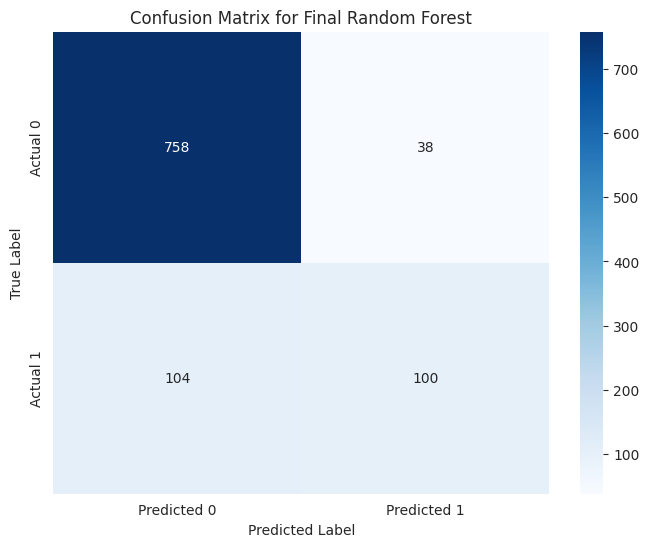

In [ ]:
# Plotting the confusion matrix.
plot_confusion_matrix(y_val, final_forest_pred, 'Final Random Forest')

In [ ]:
# Observing feature importances.
final_forest.feature_importances_

array([0.1049923 , 0.03993488, 0.02422195, 0.278081  , 0.05663244,
       0.14377848, 0.16985159, 0.00996762, 0.05662105, 0.1159187 ])

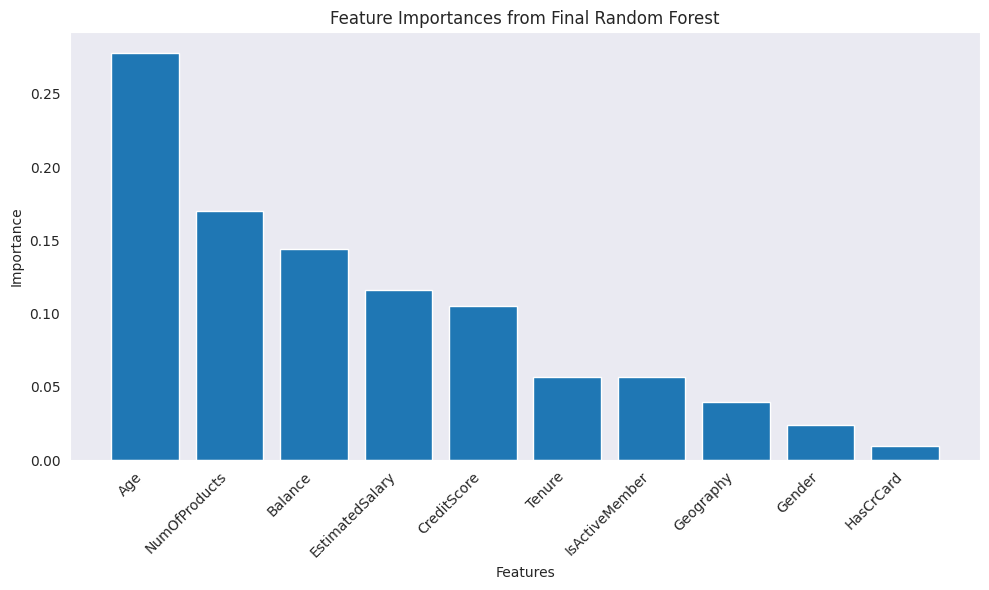

In [ ]:
# Plotting feature importances.
plot_feature_importances(final_forest, header_dict, 'Final Random Forest')

In [ ]:
model_metrics_with_changes(base_forest, final_forest, X_train, y_train, X_val, y_val)
print(f'Feature Importances: {final_forest.feature_importances_ - base_forest.feature_importances_}')

Change from Base Model

-----

Training Accuracy: -0.085
Validation Accuracy: 0.004
ROC AUC: 0.015
Precision: -0.002
Recall: 0.034

-----

[[-3  3]
 [-7  7]]

-----

Feature Importances: [-0.03853398  0.00164909  0.0053471   0.03723167 -0.02537865  0.00039833
  0.04123976 -0.01001226  0.01753071 -0.02947178]


### Comments

Similar to the Decision Tree model, the Random Forest has focused primarily on Age and NumOfProducts, but the importances of the other features are noticeably higher and the overreliance on the two core features is lower. This is likely due to the randomness of the features being demanded to build each forest. Some features may have significantly less importance than others, but the Random Forest model is forced to use at least some of them for improving accuracy. It appears that the use of more features does indeed yield a higher validation score, and it may be possible to build a highly accurate model without the use of PCA.

The tuning has reduced the training score by 0.085 but made negligible improvements in validation score. Recall has slightly improved by reducing the number of FNs but TPs have also marginally fallen.

In comparison to the decision tree model, the random forests have marginally improved in all three metrics we are observing: validation accuracy, ROC-AUC and recall. The improvement is marginal, however.

Let us now explore whether feedforward neural networks can be used to differentiate between the two.

# Deep Neural Networks

Here we will use keras to develop some neural network models to experiment with deep learning and see if we can improve upon the previous recall scores. The Decision Tree Classifier yielded a final recall 0.485 and the Random Forest Classifier yielded 0.490. The goal of the neural networks is to beat these two benchmarks.

We will first establish a base neural network model, much like what was done above with Decision Trees and Random Forests. The data has already been preprocessed with the MinMaxScaler, which is recommended for neural network processing. TensorFlow will be used to create Datasets and batch sizes will be set to a base value of 32.

The basic neural network model will use an input layer of 10 neurons (for each feature), two hidden layers of 16 neurons, and a final output layer of 1 neuron. The hidden layers will both use a RELU activation, which has been proven to converge at a high speed for most data structures. The final layer will be a sigmoid activation to distinguish between the likelihood of churn (1) or not-churn (0).

The model will be trained using an ADAM optimizer and the loss will be calculated using Binary Cross Entropy. Hyperparameters to be explored include model depth, model breadth, activation functions, dropout layers and batch size.

## Functions

In [27]:
def create_datasets(X_train, y_train, X_val, y_val, batch_size):

  # Creating the training dataset.
  features = tf.data.Dataset.from_tensor_slices(X_train)
  labels = tf.data.Dataset.from_tensor_slices(y_train)
  training_dataset = tf.data.Dataset.zip((features, labels))

  # Creating the validation dataset.
  val_features = tf.data.Dataset.from_tensor_slices(X_val)
  val_labels = tf.data.Dataset.from_tensor_slices(y_val)
  validation_dataset = tf.data.Dataset.zip((val_features, val_labels))

  # Shuffling and establishing batch sizes.
  training_dataset = training_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)
  validation_dataset = validation_dataset.batch(batch_size=batch_size)

  return training_dataset, validation_dataset

In [28]:
def train_model(model_architecture, epochs, batch_size, verbosity):

  # Creating new instance of model.
  training_dataset, validation_dataset = create_datasets(X_train, y_train, X_val, y_val, batch_size)
  model = model_architecture()

  # Fitting the model to the datasets.
  history = model.fit(training_dataset, validation_data=validation_dataset, epochs=epochs, verbose=verbosity)

  return history

In [32]:
def plot_history(history, title):

  # Distinguishing between training and validation losses and accuracies.
  acc = history.history['recall']
  val_acc = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  # Plotting the figures.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  fig.suptitle(f'Training Loss & Recall for {title}')

  for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Recall", "Loss"])):
      ax[i].plot(epochs, data[0], 'r', label="Training " + label)
      ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
      ax[i].legend()
      ax[i].set_xlabel('epochs')

  plt.show()

## Basic Model

In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
def basic_model():

  # Establishing a basic model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [35]:
# Examining model parameters.
test_model = basic_model()
test_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 465 (1.82 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
%%time

# Training model.
basic_model_history = train_model(basic_model, 100, 32, 1)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6041 - recall: 0.2495 - val_loss: 0.4729 - val_recall: 0.0000e+00
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4809 - recall: 1.2610e-04 - val_loss: 0.4531 - val_recall: 0.0098
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4621 - recall: 0.0320 - val_loss: 0.4296 - val_recall: 0.1275
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4393 - recall: 0.1253 - val_loss: 0.4136 - val_recall: 0.2696
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4307 - recall: 0.2015 - val_loss: 0.4044 - val_recall: 0.3235
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4210 - recall: 0.2329 - val_loss: 0.3948 - val_recall: 0.3775
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4049 - recall: 0.2717 - val_loss: 0.3809 - val_recall: 0.3480
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3889 - recall: 0.3082 - val_loss: 0.3701 - val_recall:

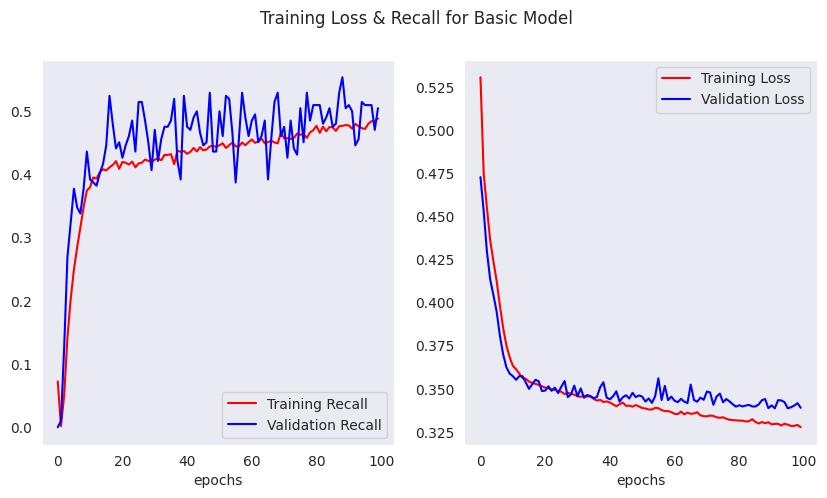

In [37]:
plot_history(basic_model_history, 'Basic Model')

### Comments

Validation loss plateaus a bit after 40 epochs. It hovers around 0.350 for the final 60 epochs. This model can be used as a bench mark for various architectures going forward.

Note that the validation recall tends to be erratic but generall trending in the right direction.

## Exploring Model Depth

In [38]:
def deep_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [39]:
# Examining model parameters.
test_model = deep_model()
test_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,009 (3.94 KB)

 Trainable params: 1,009 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
%%time

# Training model.
deep_model_history = train_model(deep_model, 100, 32, 0)

CPU times: user 1min 13s, sys: 5.45 s, total: 1min 19s
Wall time: 1min 11s


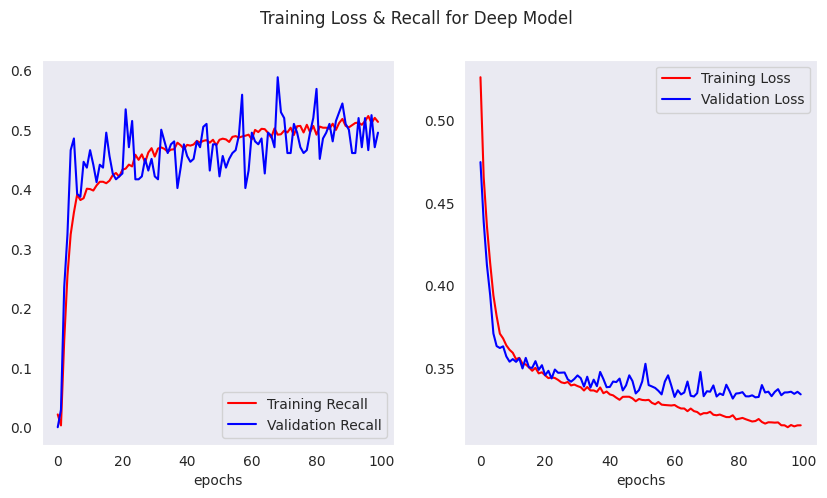

In [41]:
plot_history(deep_model_history, 'Deep Model')

### Comments

This model used four hidden layers rather than just two. The number of neurons was maintained at 16 for the two extra hidden layers. We can see that the model begins to overfit the data after the 20th epoch. The training loss begins to noticeably decrease but the validation loss remains relatively constant. As far as validation loss goes, there isn't much of an improvement on the previous model. The training recall is relatively stable but the validation recall remains highly erratic.

## Exploring Model Breadth

In [42]:
def broad_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [43]:
# Examining model parameters.
test_model = broad_model()
test_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,865 (269.00 KB)

 Trainable params: 68,865 (269.00 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
%%time

# Training model.
broad_model_history = train_model(broad_model, 100, 32, 0)

CPU times: user 1min 9s, sys: 5.3 s, total: 1min 15s
Wall time: 1min 7s


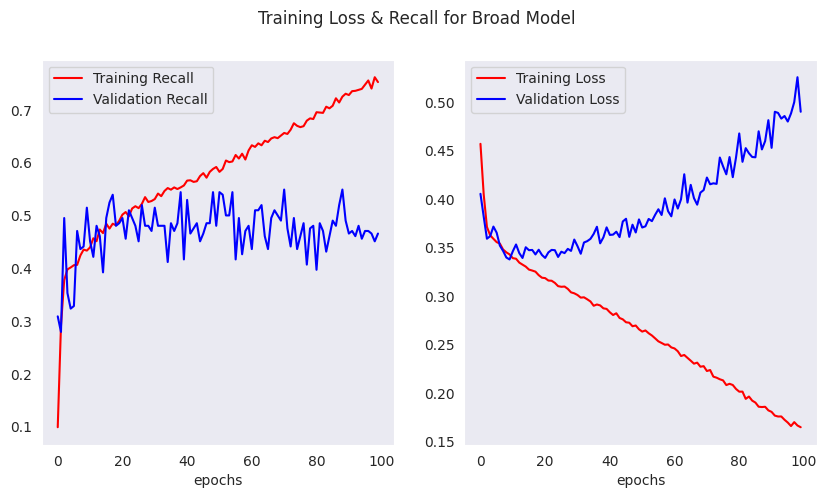

In [45]:
plot_history(broad_model_history, 'Broad Model')

### Comments

This architecture maintains two hidden layers but increases the number of neurons of both layers to 256. The intention is to see if the addition of neurons is able to capture more complex relationships between the features.

The validation loss reaches 0.35 by the 20th epoch but rises earlier steeply afterwards. It reaches to roughly 0.45 by the end. As we can see, the broader model is highly prone to overfitting. It may be possible to mitigate this through Dropout layers which force the model to restructure its neural connections to more efficacious ones. This will be explored further later.

## Combining Increased Depth with Increased Breadth

In [46]:
def mixed_model_1():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [47]:
def mixed_model_2():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [48]:
# Examining model parameters.
test_model = mixed_model_1()
test_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Examining model parameters.
test_model = mixed_model_2()
test_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,073 (199.50 KB)

 Trainable params: 51,073 (199.50 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
%%time

# Training model.
mixed_model_1_history = train_model(mixed_model_1, 100, 32, 0)

CPU times: user 1min 16s, sys: 5.54 s, total: 1min 22s
Wall time: 1min 17s


In [51]:
%%time

# Training model.
mixed_model_2_history = train_model(mixed_model_2, 100, 32, 0)

CPU times: user 1min 14s, sys: 5.24 s, total: 1min 19s
Wall time: 1min 11s


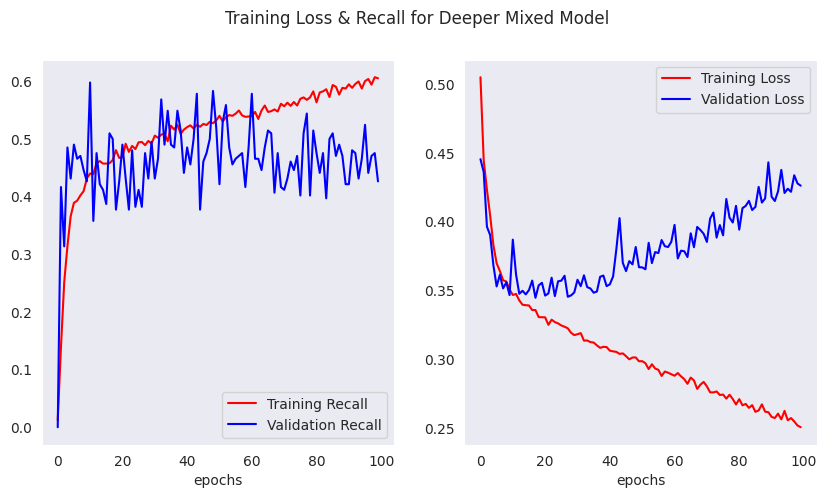

In [52]:
plot_history(mixed_model_1_history, 'Deeper Mixed Model')

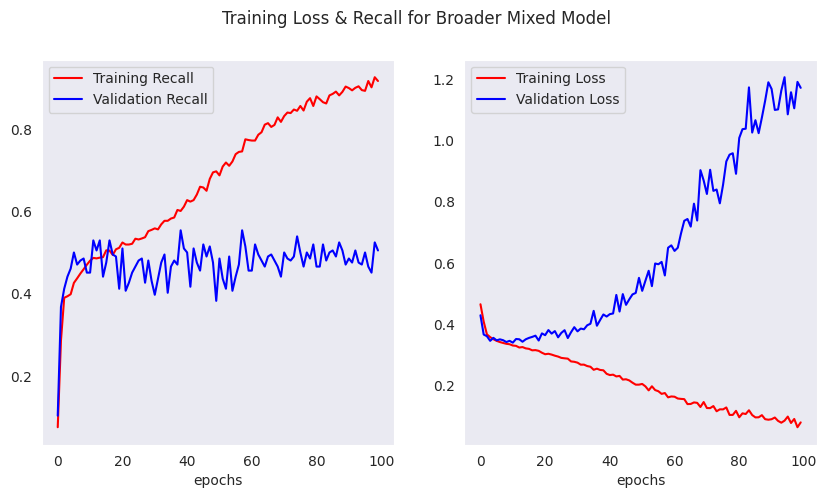

In [53]:
plot_history(mixed_model_2_history, 'Broader Mixed Model')

### Comments

Two mixed models were looked at: Model 1 is more deep than broad whereas Model 2 is more broad than deep. Much like the previous instances, the mixed model visibly overfits within 100 epochs. Model 1 reaches a validation loss of 0.400 after 100 epochs while Model 2 reaches 1.600. It appears that adding model breadth is more conducive to overfitting than model depth, hence it may be argued that this dataset requires a narrow neural network to achieve a high accuracy.

We will attempt to mitigate the overfitting for deeper structures in the following subsections by exploring changes in the activation function, the batch size and some dropout layers.

## Exploring L1 Regularization

Here we will take a look at L1 regularization, which adds an absolute sum of the weights to the cost function and consequently pushes some of the feature importances to zero. L1 regularization can be thought of as a form of "feature selection" with neurons. We already saw with the Decision Tree model that an accurate model does not necessarily require all features to be used. We will see here if the same applies to neural connections.

In [54]:
def l1_model(reg_value):

  # Establishing a basic model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(reg_value)),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(reg_value)),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [55]:
# Examining model parameters.
test_model = l1_model(0.1)
test_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 465 (1.82 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

Regularization Value: 0.0001



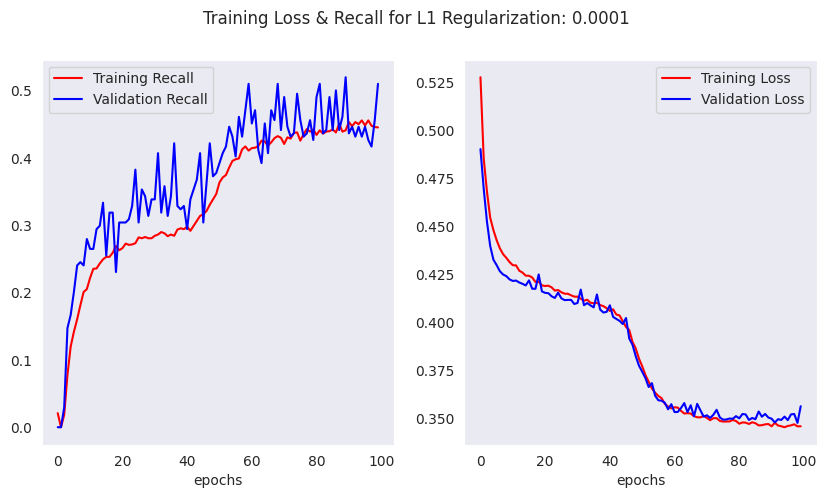


-----

Regularization Value: 0.0002



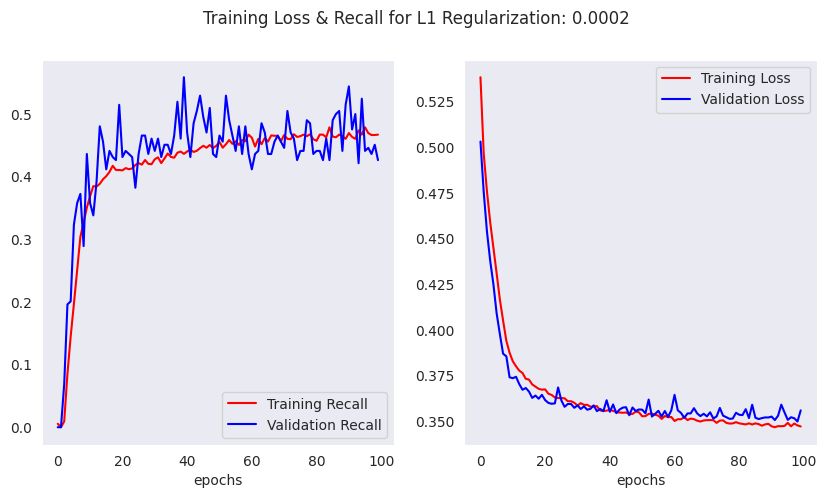


-----

Regularization Value: 0.0005



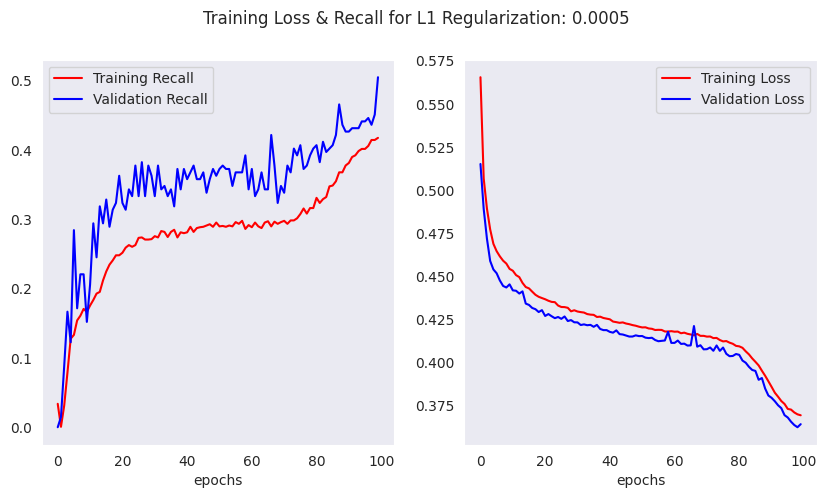


-----

Regularization Value: 0.001



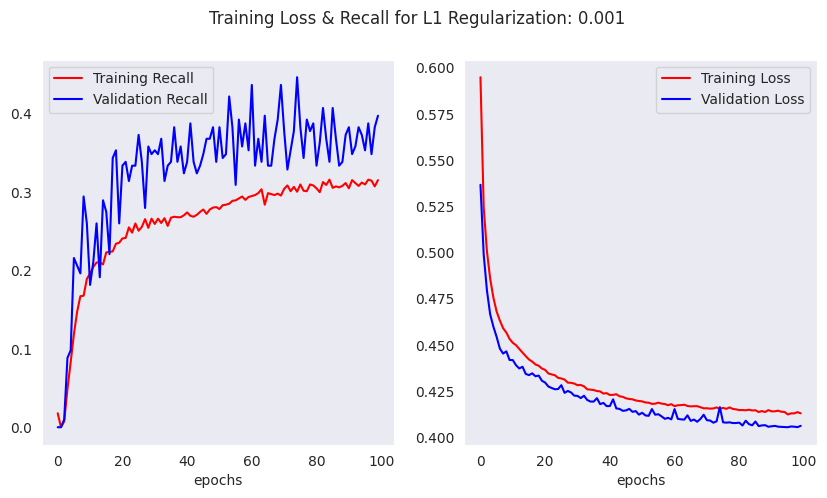


-----

Regularization Value: 0.0025



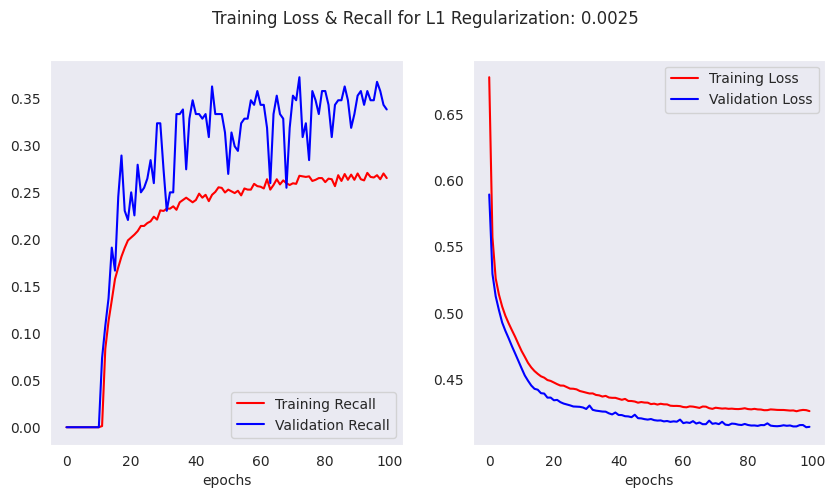


-----

CPU times: user 5min 49s, sys: 26.3 s, total: 6min 16s
Wall time: 5min 38s


In [56]:
%%time

reg_values = [0.0001, 0.0002, 0.0005, 0.001, 0.0025]

for reg_value in reg_values:
  print(f"Regularization Value: {reg_value}\n")

  l1_model_history = train_model(lambda: l1_model(reg_value), 100, 32, 0)
  plot_history(l1_model_history, f'L1 Regularization: {reg_value}')
  print('\n-----\n')

While L1 regularization certainly smoothes out the losses, the validation loss steadily increases with the L1 value. It might only be possible to include L1 regularization with a very low value of L1 and observe  loss with greater epochs.

## Exploring Activation Functions

The previous models had all used RELU functions in the hidden layers. RELU was chosen due to its robustness across a variety of models. RELU's weakness, however, is that all logits below zero are set to simply zero. Hence no gradient optimization can be done for negative values of z=wx+b. As a result, three additional activation functions will be looked at here.

The Exponential Linear Unit (ELU) function set the negative activation to alpha * (exp(x) - 1), which steadily converges to a value of -1. Its positive activation value is simply z (the same as RELU). This choice of negative activation function is expected to steadily push the mean of the activation values to zero, thereby pushing the gradient closer to the "true gradient" than would otherwise happen with RELU.

The Sigmoid-Weighted Linear Unit (SILU, also known as Swish) has an activation function of x * sigmoid(x). The activation values function very similarly to a RELU but has an activation value which dips into the negative before converging to zero from the bottom. The Gaussian Error Linear Unit (GELU) functions similarly to SILU but the activation function is multiplied with phi(x), where phi is the standard Gaussian cumulative distribution.

### Basic Model with ELU

In [57]:
def basic_elu_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [58]:
# Examining model parameters.
test_model = basic_elu_model()
test_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                     │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 465 (1.82 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
%%time

# Training model.
basic_elu_model_history = train_model(basic_elu_model, 100, 32, 0)

CPU times: user 1min 9s, sys: 5.16 s, total: 1min 14s
Wall time: 1min 6s


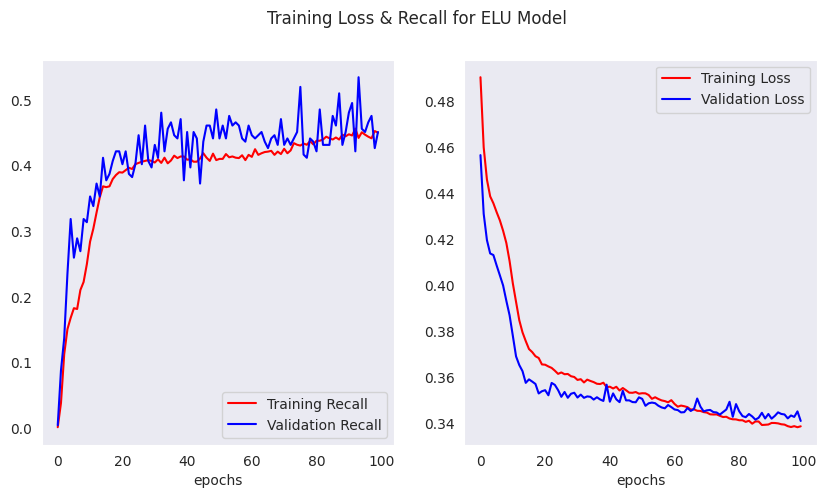

In [60]:
plot_history(basic_elu_model_history, 'ELU Model')

### Basic Model with GELU

In [61]:
def basic_gelu_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [62]:
# Examining model parameters.
test_model = basic_gelu_model()
test_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                     │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 465 (1.82 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
%%time

# Training model.
basic_gelu_model_history = train_model(basic_gelu_model, 100, 32, 0)

CPU times: user 1min 9s, sys: 5.28 s, total: 1min 14s
Wall time: 1min 6s


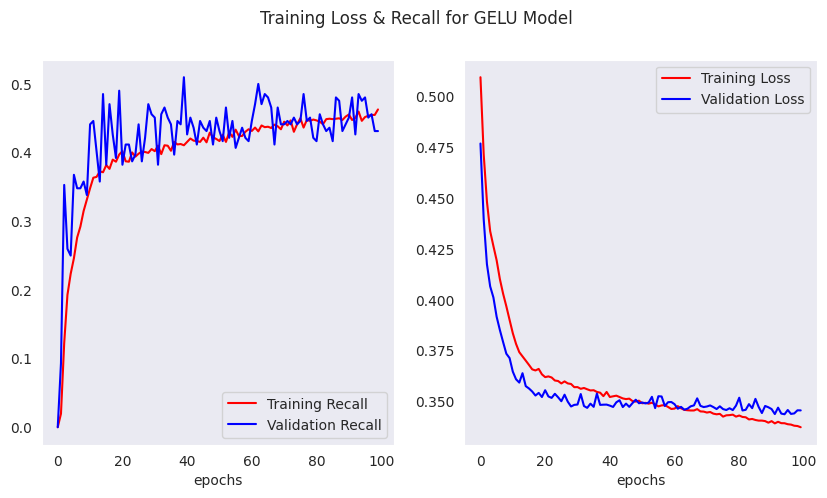

In [64]:
plot_history(basic_gelu_model_history, 'GELU Model')

### Basic Model with SILU

In [65]:
def basic_silu_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [66]:
# Examining model parameters.
test_model = basic_silu_model()
test_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                     │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 465 (1.82 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
%%time

# Training model.
basic_silu_model_history = train_model(basic_silu_model, 100, 32, 0)

CPU times: user 1min 9s, sys: 5.26 s, total: 1min 14s
Wall time: 1min 6s


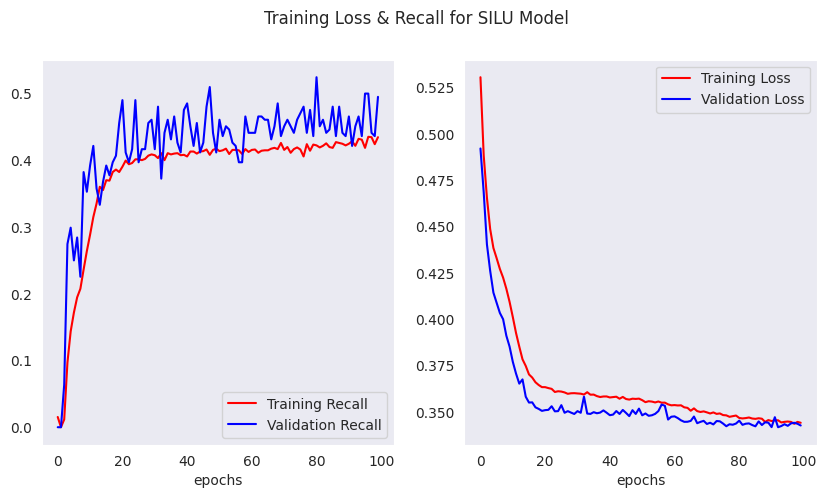

In [68]:
plot_history(basic_silu_model_history, 'SILU Model')

### Comments

The following observations can be made:
- The ELU model is not as smooth as the SILU but maintains a close consistency with the training loss. ELU also takes the longest to converge to a validation loss around 0.350.
- The GELU model converges quickly to 0.350 within 20 epochs and ends up with the lowest loss.
- The SILU model is somewhere in between. It has a validation loss which falls below the training loss and converges at around 25 epochs, and stays relatively close to the training loss afterwards.

All three models are otherwise similar to the basic RELU model. Differences will likely only be seen once the models are trained for extended periods.


### Deep Model with ELU

In [69]:
def deep_elu_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [70]:
test_model = deep_elu_model()
test_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                     │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,009 (3.94 KB)

 Trainable params: 1,009 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
%%time

deep_elu_model_history = train_model(deep_elu_model, 100, 32, 0)

CPU times: user 1min 12s, sys: 5.44 s, total: 1min 18s
Wall time: 1min 8s


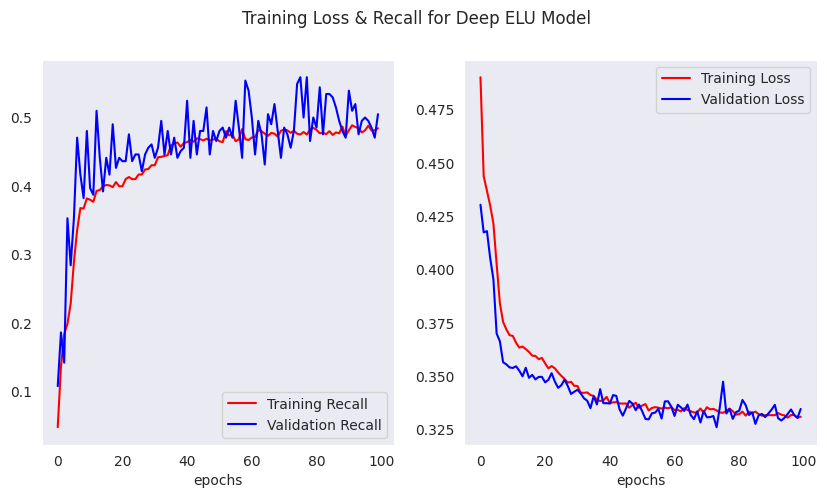

In [72]:
plot_history(deep_elu_model_history, 'Deep ELU Model')

### Deep Model with GELU

In [73]:
def deep_gelu_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [74]:
test_model = deep_gelu_model()
test_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                     │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,009 (3.94 KB)

 Trainable params: 1,009 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
%%time

deep_gelu_model_history = train_model(deep_gelu_model, 100, 32, 0)

CPU times: user 1min 12s, sys: 5.56 s, total: 1min 18s
Wall time: 1min 9s


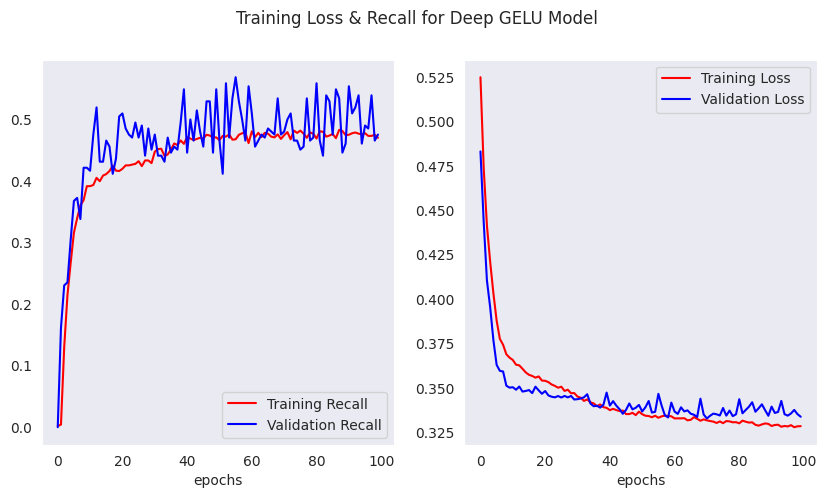

In [76]:
plot_history(deep_gelu_model_history, 'Deep GELU Model')

### Deep Model with SILU

In [77]:
def deep_silu_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [78]:
test_model = deep_silu_model()
test_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)                    │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,009 (3.94 KB)

 Trainable params: 1,009 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
%%time

deep_silu_model_history = train_model(deep_silu_model, 100, 32, 0)

CPU times: user 1min 14s, sys: 5.46 s, total: 1min 19s
Wall time: 1min 21s


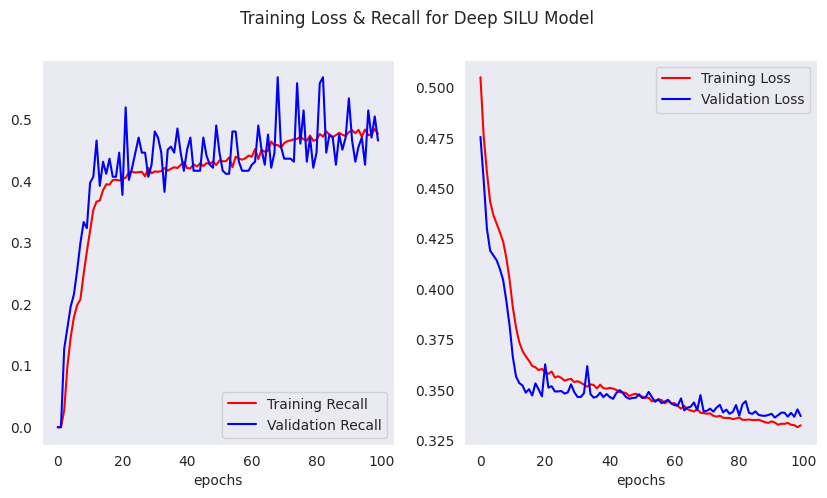

In [80]:
plot_history(deep_silu_model_history, 'Deep SILU Model')

### Comments

All three models respond well to increased depth. None of the show signs of overfitting. The ELU model converges much faster with 4 hidden layers rather than 2. The GELU model may be slightly overfitting near the end of 100 epochs - one can see the validation and training losses diverge. The extent to which it overfits can only be seen with an increase in the number of epochs.

## Exploring Various Batch Sizes

Although various batch sizes are recommended, we will solely experiment with sizes 16, 32, 64, and 128 since we only have 8000 training examples. The deep SILU model seems to achieve the lowest validation loss, so it will be the model of choice going forward.

Batch Size: 16



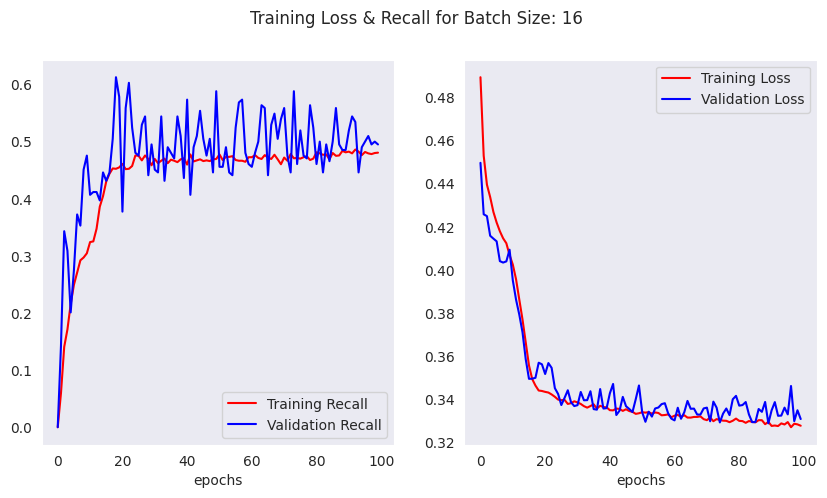


-----

Batch Size: 32



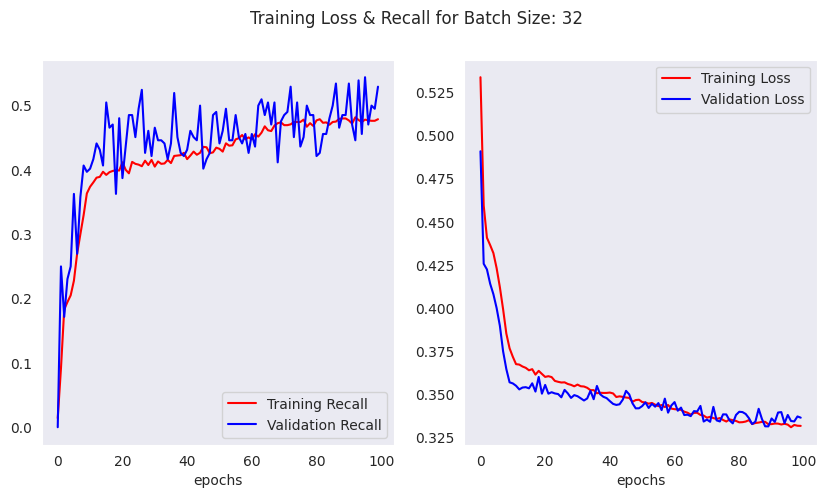


-----

Batch Size: 64



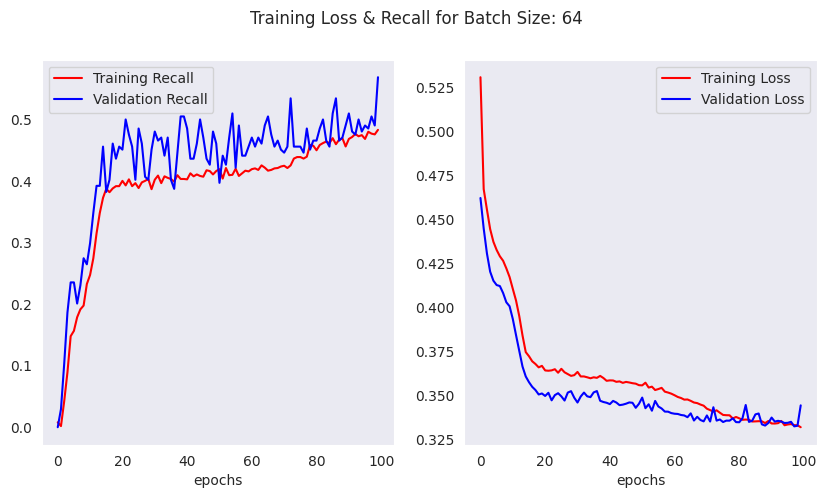


-----

Batch Size: 128



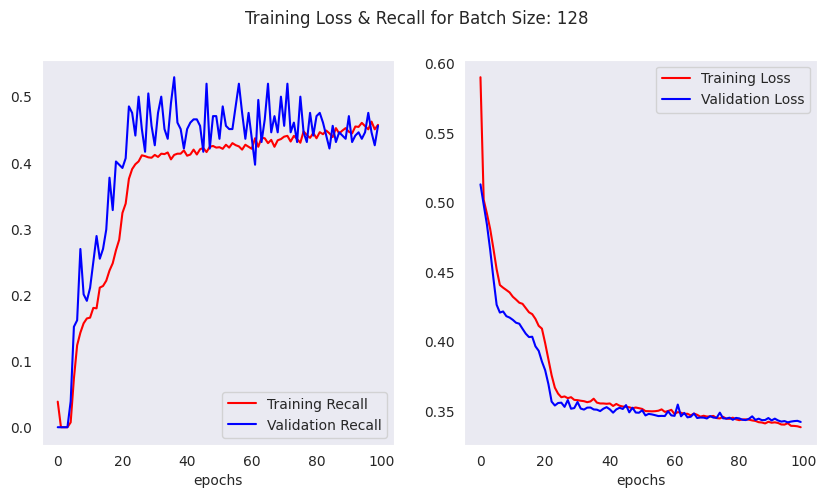


-----

Batch Size: 256



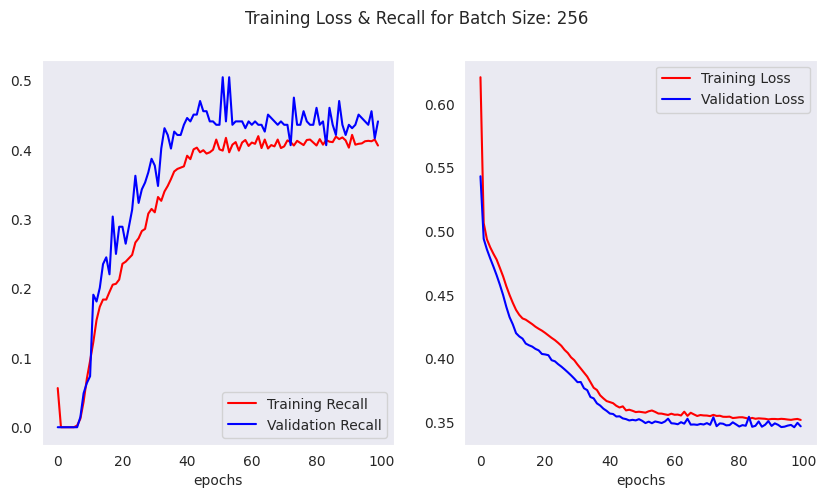


-----

CPU times: user 4min 56s, sys: 22.1 s, total: 5min 18s
Wall time: 4min 53s


In [81]:
%%time

batch_sizes = [16, 32, 64, 128, 256]

for batch_size in batch_sizes:
  print(f"Batch Size: {batch_size}\n")
  history = train_model(deep_silu_model, 100, batch_size, 0)
  plot_history(history, f'Batch Size: {batch_size}')
  print('\n-----\n')

### Comments

Batch sizes of 32 or 64 are probably best with 16 being a probable choice. Batches of 128 or 256 are too large for this dataset and risk being stuck inside a local minima, although the graphs are quite smooth.

## Exploring Dropout Layers

In [82]:
def deep_silu_model_with_dropout(input_dropout, hidden_dropout):

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dropout(input_dropout),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [83]:
test_model = deep_silu_model_with_dropout(0.1, 0.2)
test_model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,009 (3.94 KB)

 Trainable params: 1,009 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
%%time

# Fitting the model to the datasets.
deep_silu_model_with_dropout_history = train_model(lambda: deep_silu_model_with_dropout(0.1, 0.2), 250, 32, 0)

CPU times: user 3min 6s, sys: 13 s, total: 3min 19s
Wall time: 3min 1s


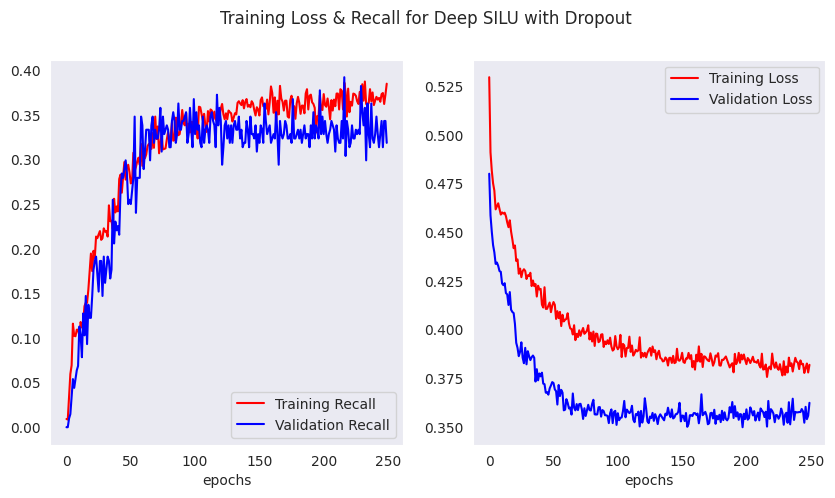

In [85]:
# Testing the model over 250 epochs.
plot_history(deep_silu_model_with_dropout_history, 'Deep SILU with Dropout')

Batch Size: 32, Input Dropout: 0.1, Hidden Dropout: 0.2



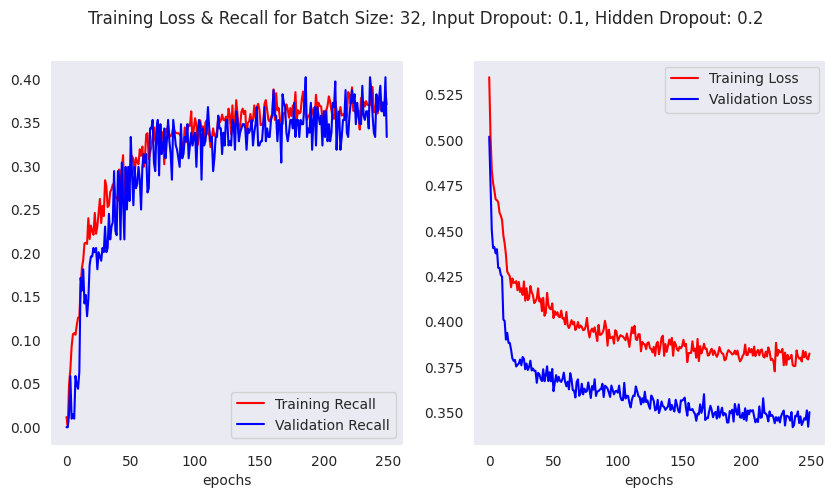


-----

Batch Size: 32, Input Dropout: 0.1, Hidden Dropout: 0.3



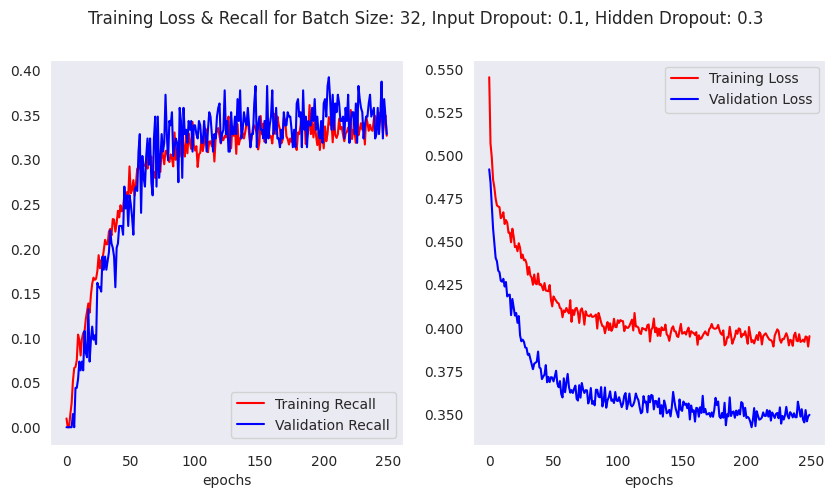


-----

Batch Size: 32, Input Dropout: 0.1, Hidden Dropout: 0.4



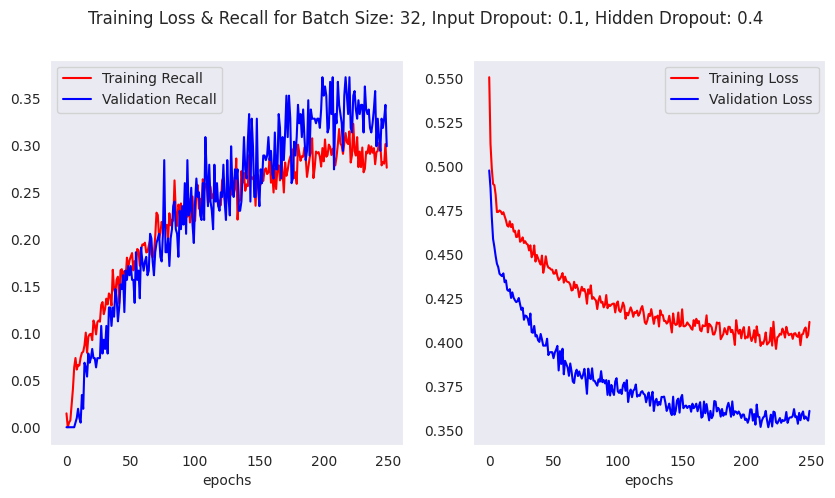


-----

Batch Size: 32, Input Dropout: 0.25, Hidden Dropout: 0.2



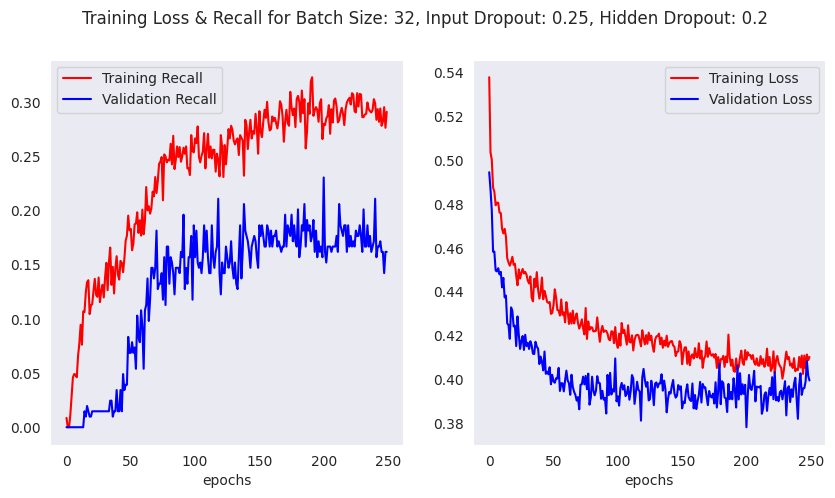


-----

Batch Size: 32, Input Dropout: 0.25, Hidden Dropout: 0.3



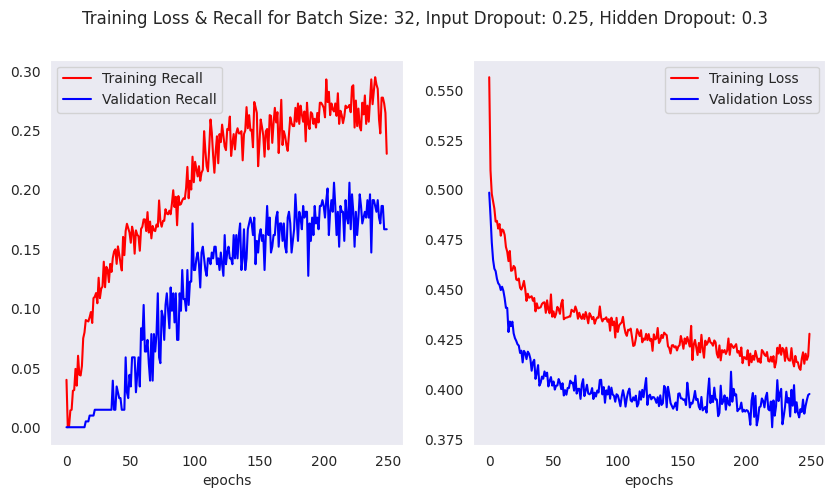


-----

Batch Size: 32, Input Dropout: 0.25, Hidden Dropout: 0.4



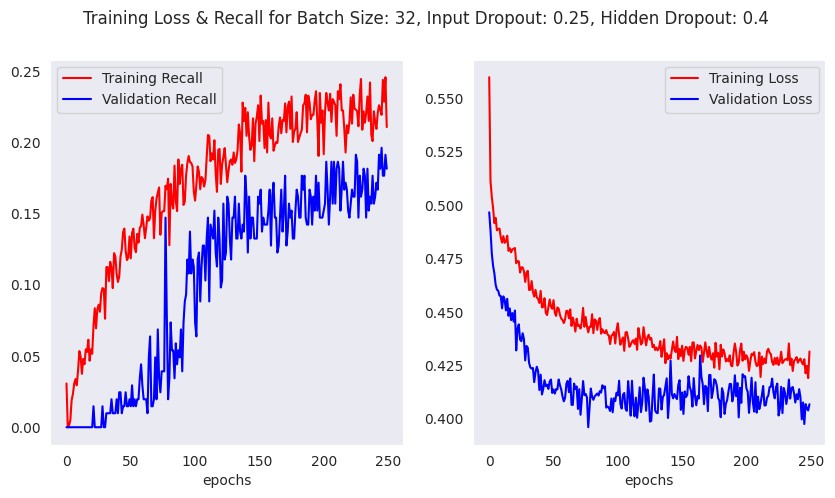


-----

Batch Size: 64, Input Dropout: 0.1, Hidden Dropout: 0.2



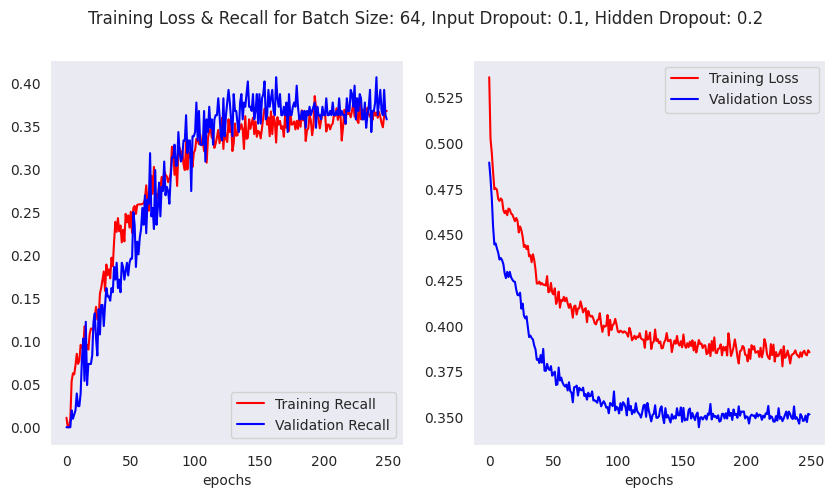


-----

Batch Size: 64, Input Dropout: 0.1, Hidden Dropout: 0.3



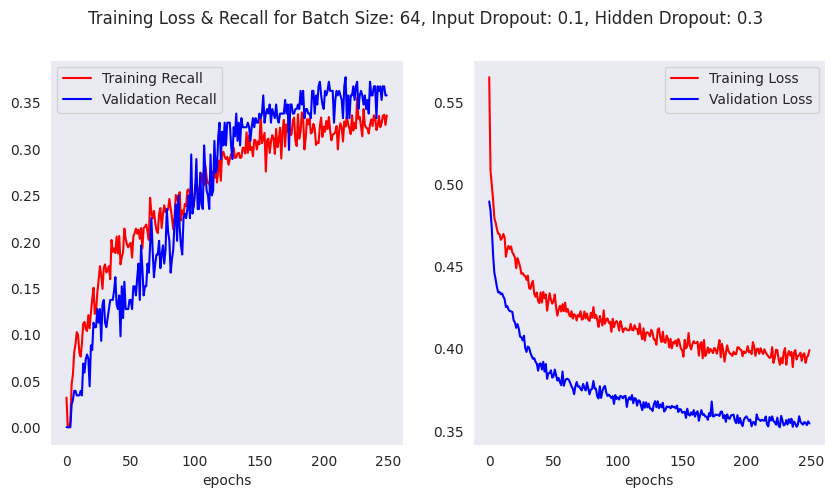


-----

Batch Size: 64, Input Dropout: 0.1, Hidden Dropout: 0.4



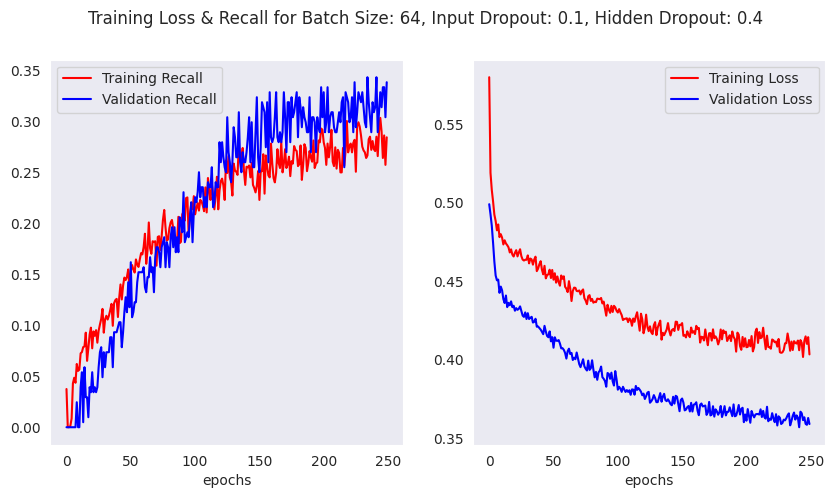


-----

Batch Size: 64, Input Dropout: 0.25, Hidden Dropout: 0.2



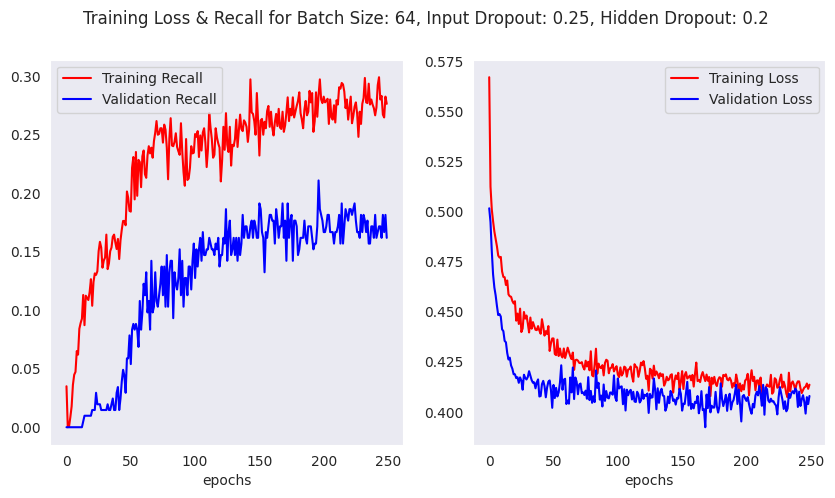


-----

Batch Size: 64, Input Dropout: 0.25, Hidden Dropout: 0.3



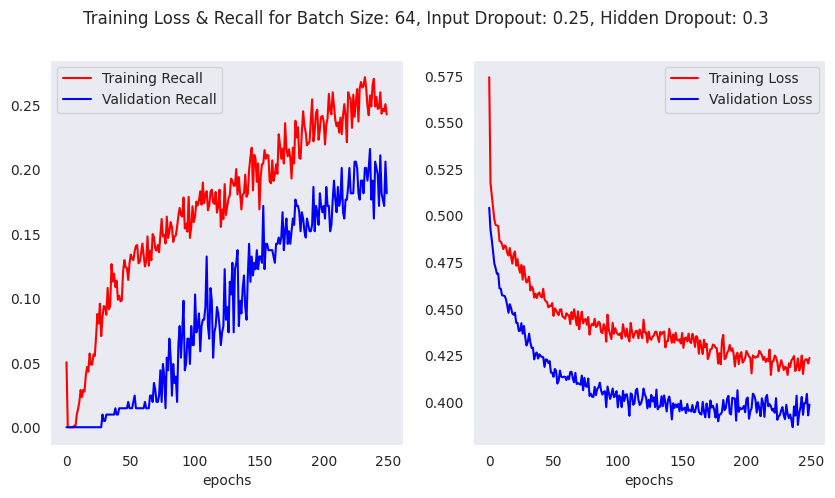


-----

Batch Size: 64, Input Dropout: 0.25, Hidden Dropout: 0.4



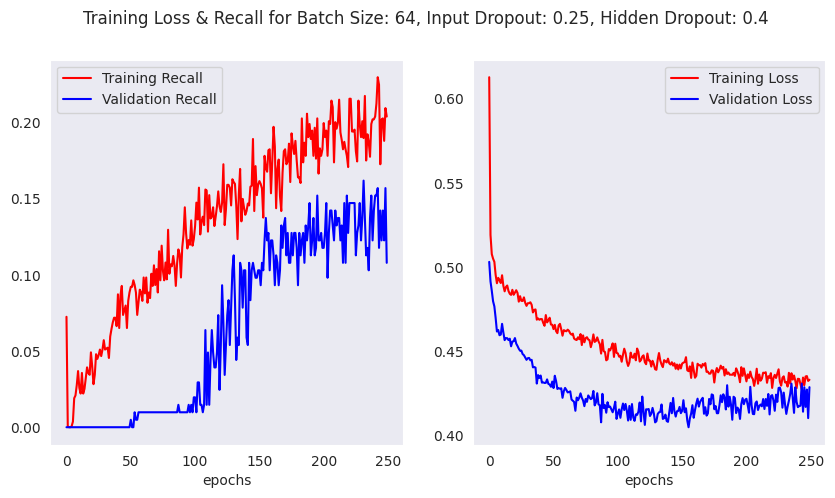


-----

CPU times: user 29min 1s, sys: 2min, total: 31min 2s
Wall time: 29min 47s


In [86]:
# Training the model with a set of batch sizes and dropout ranges.

%%time

batch_sizes = [32, 64]
input_dropout_range = [0.1, 0.25]
hidden_dropout_range = [0.2, 0.3, 0.4]

for batch_size in batch_sizes:
  for input_dropout in input_dropout_range:
    for hidden_dropout in hidden_dropout_range:
      print(f"Batch Size: {batch_size}, Input Dropout: {input_dropout}, Hidden Dropout: {hidden_dropout}\n")
      history = train_model(lambda: deep_silu_model_with_dropout(input_dropout, hidden_dropout), 250, batch_size, 0)
      plot_history(history, str.format(f'Batch Size: {batch_size}, Input Dropout: {input_dropout}, Hidden Dropout: {hidden_dropout}'))
      print('\n-----\n')

### Comments

Dropout rates seem to be useful at smaller values but don't seem to otherwise lead to lower losses. Batch size of 32 seems to respond better to dropout than 64, but 64 is smoother.

## Training over Longer Epochs

As we have seen above, the broader models seem unable to generalize the model well. Deeper models perform reasonably well so long as the number of neurons remain few in number. All three of ELU, GELU and SILU seem to perform better than RELU, with batch sizes 32 and 64 fitting particularly well. As a result, let us train the following models for 1000 epochs each and record the respective validation losses and accuracy scores.

- 3-layer models with RELU, ELU, GELU & SILU
- 5-layer models with RELU, ELU, GELU & SILU
- 5-layer models with dropout values of (0.1, 0.2)

In [87]:
%%time

basic_model_history = train_model(basic_model, 1000, 32, 0)
basic_elu_model_history = train_model(basic_elu_model, 1000, 32, 0)
basic_gelu_model_history = train_model(basic_gelu_model, 1000, 32, 0)
basic_silu_model_history = train_model(basic_silu_model, 1000, 32, 0)

CPU times: user 44min 59s, sys: 3min 13s, total: 48min 13s
Wall time: 42min 38s


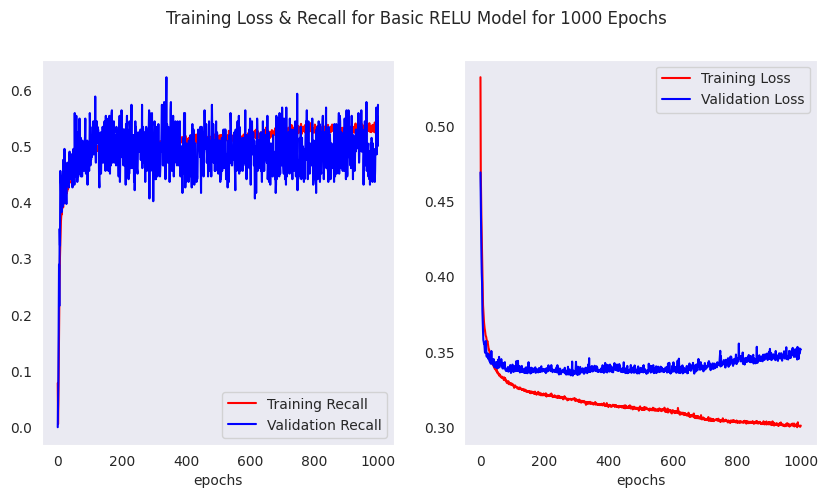

In [88]:
plot_history(basic_model_history, 'Basic RELU Model for 1000 Epochs')

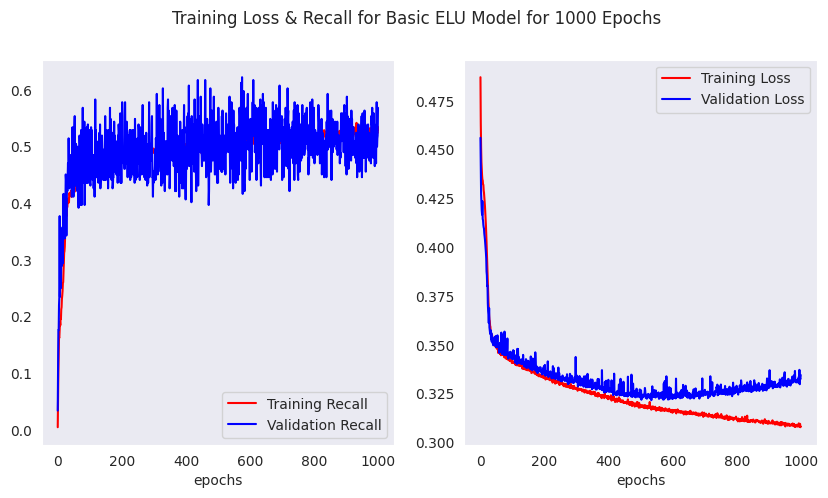

In [89]:
plot_history(basic_elu_model_history, 'Basic ELU Model for 1000 Epochs')

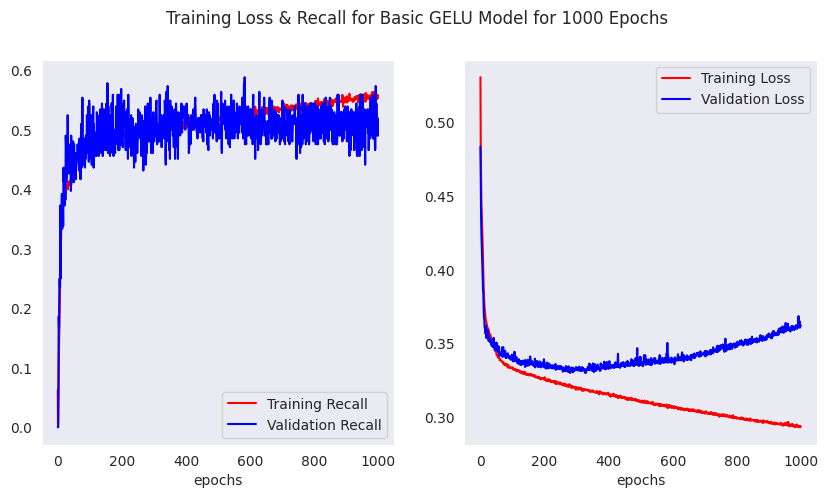

In [90]:
plot_history(basic_gelu_model_history, 'Basic GELU Model for 1000 Epochs')

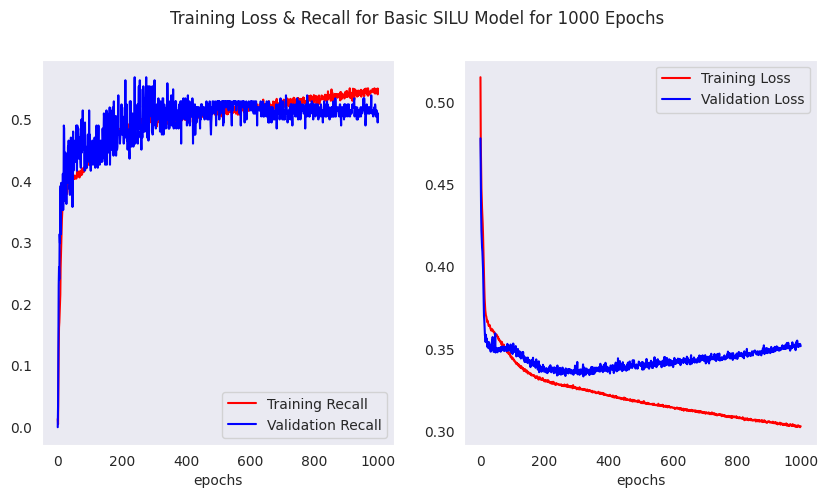

In [91]:
plot_history(basic_silu_model_history, 'Basic SILU Model for 1000 Epochs')

### Comments

The lowest losses seem to occur with batch sizes of 64 and dropout rates of (0.1, 0.1). Both the deep ELU and SILU models seem to converge at roughly 0.340. The basic models with similar dropout rates seems to have a similar convergence. The models with these hyperparameters are also not overfitting. It is possible that a couple of these deeper models might be the most promising one to run for longer epochs and finalize as our ultimate choice.

In [92]:
# Building model.
def deep_model_with_dropout():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [93]:
# Examining model parameters.
test_model = deep_model_with_dropout()
test_model.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_70 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_217 (Dense)                    │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_218 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_219 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_220 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_221 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,009 (3.94 KB)

 Trainable params: 1,009 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
%%time

deep_model_with_dropout_history = train_model(deep_model_with_dropout, 1000, 32, 0)

CPU times: user 12min 11s, sys: 51.9 s, total: 13min 3s
Wall time: 11min 53s


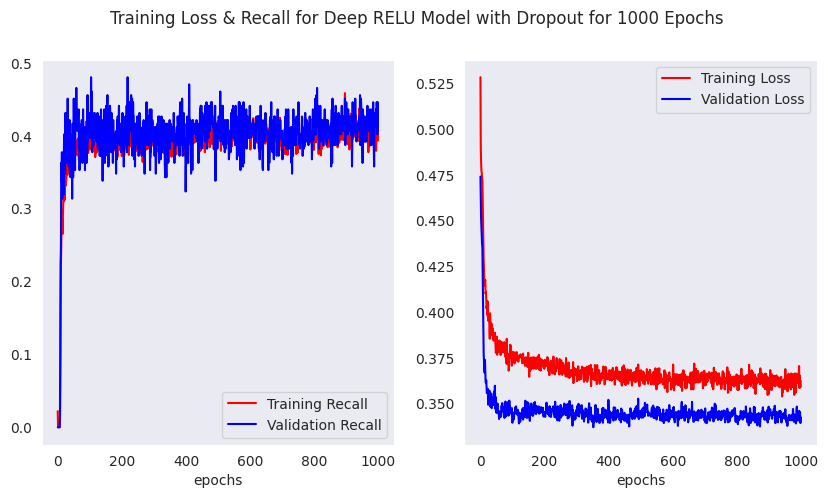

In [95]:
plot_history(deep_model_with_dropout_history, 'Deep RELU Model with Dropout for 1000 Epochs')

In [96]:
# Building model.
def deep_model_with_dropout2():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [97]:
test_model = deep_model_with_dropout2()
test_model.summary()

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_227 (Dense)                    │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_228 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_229 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_230 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_231 (Dense)                    │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081 (8.13 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
%%time

deep_model_with_dropout2_history = train_model(deep_model_with_dropout2, 1000, 32, 0)

CPU times: user 12min 10s, sys: 52.2 s, total: 13min 2s
Wall time: 11min 53s


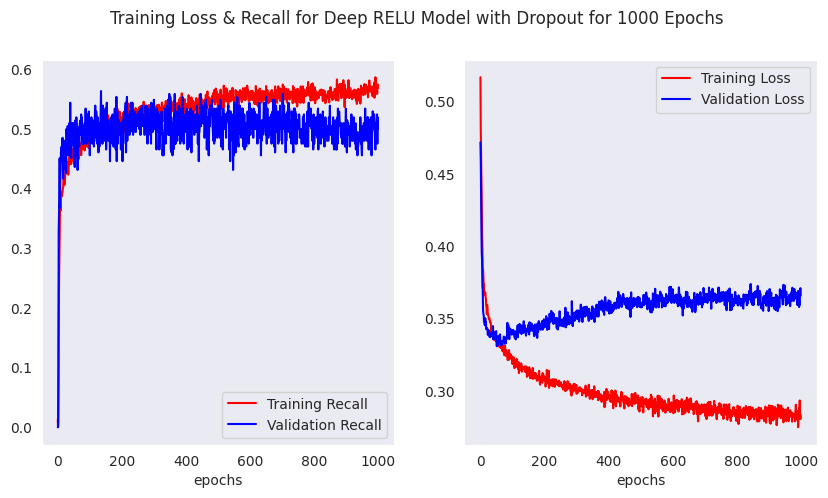

In [99]:
plot_history(deep_model_with_dropout2_history, 'Deep RELU Model with Dropout for 1000 Epochs')

In [100]:
%%time

deep_elu_model_history = train_model(deep_elu_model, 1000, 32, 0)

CPU times: user 11min 48s, sys: 51.2 s, total: 12min 39s
Wall time: 11min 11s


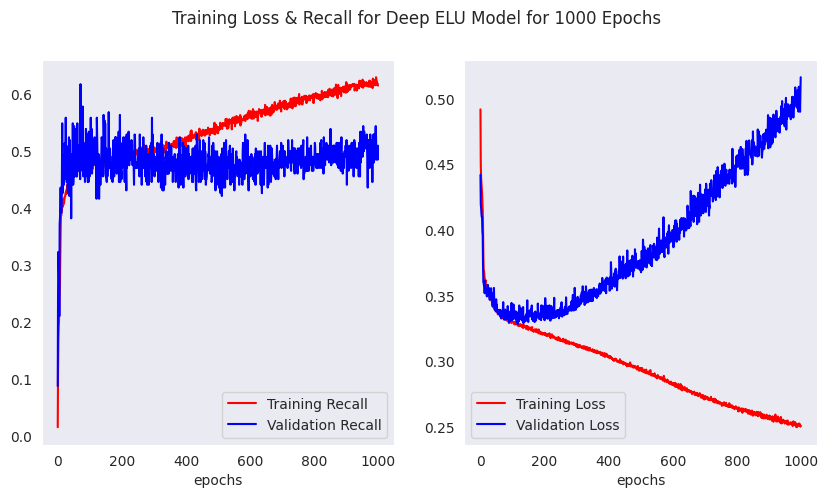

In [101]:
plot_history(deep_elu_model_history, 'Deep ELU Model for 1000 Epochs')

In [102]:
%%time

deep_gelu_model_history = train_model(deep_gelu_model, 1000, 32, 0)

CPU times: user 11min 45s, sys: 52.5 s, total: 12min 37s
Wall time: 11min 10s


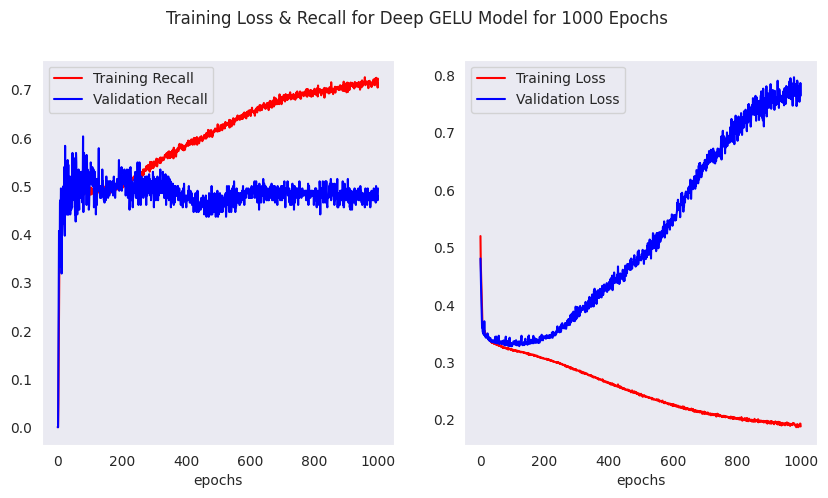

In [103]:
plot_history(deep_gelu_model_history, 'Deep GELU Model for 1000 Epochs')

In [104]:
%%time

deep_silu_model_history = train_model(deep_silu_model, 1000, 32, 0)

CPU times: user 11min 44s, sys: 51.3 s, total: 12min 35s
Wall time: 11min 11s


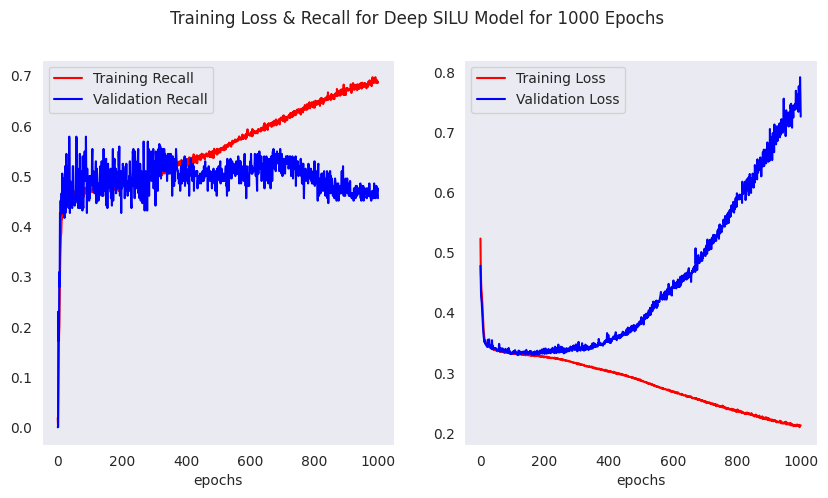

In [105]:
plot_history(deep_silu_model_history, 'Deep SILU Model for 1000 Epochs')

## Final Model

In [ ]:
def final_model_elu():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [ ]:
%%time

final_model_1 = final_model_elu()
final_model_1_history = final_model_1.fit(X_train, y_train, epochs=10000, batch_size=64, validation_data=(X_val, y_val), verbose=0)

Streaming output truncated to the last 5000 lines.
Epoch 7502/10000
125/125 - 0s - 2ms/step - accuracy: 0.8495 - loss: 0.3646 - val_accuracy: 0.8620 - val_loss: 0.3416
Epoch 7503/10000
125/125 - 0s - 2ms/step - accuracy: 0.8476 - loss: 0.3693 - val_accuracy: 0.8620 - val_loss: 0.3424
Epoch 7504/10000
125/125 - 0s - 2ms/step - accuracy: 0.8496 - loss: 0.3694 - val_accuracy: 0.8630 - val_loss: 0.3427
Epoch 7505/10000
125/125 - 0s - 2ms/step - accuracy: 0.8493 - loss: 0.3691 - val_accuracy: 0.8620 - val_loss: 0.3420
Epoch 7506/10000
125/125 - 0s - 2ms/step - accuracy: 0.8510 - loss: 0.3603 - val_accuracy: 0.8630 - val_loss: 0.3426
Epoch 7507/10000
125/125 - 0s - 2ms/step - accuracy: 0.8506 - loss: 0.3637 - val_accuracy: 0.8630 - val_loss: 0.3413
Epoch 7508/10000
125/125 - 0s - 2ms/step - accuracy: 0.8535 - loss: 0.3630 - val_accuracy: 0.8630 - val_loss: 0.3426
Epoch 7509/10000
125/125 - 0s - 2ms/step - accuracy: 0.8494 - loss: 0.3672 - val_accuracy: 0.8610 - val_loss: 0.3412
Epoch 7510/10

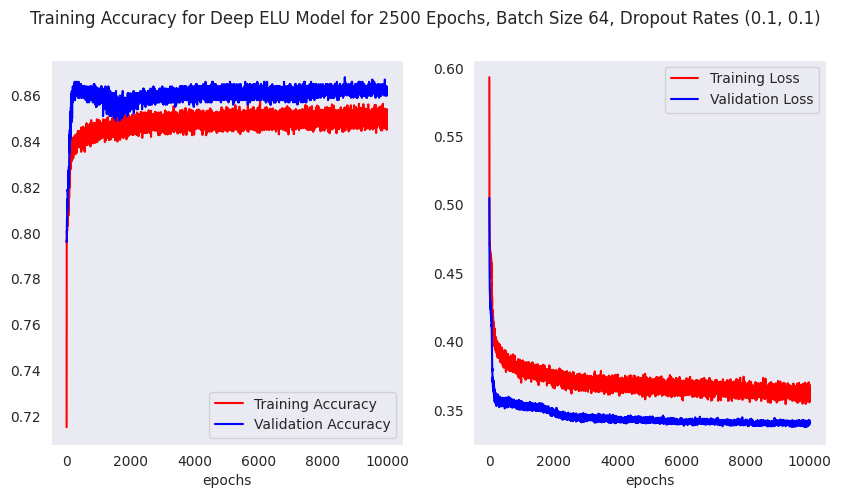

In [ ]:
plot_history(final_model_1_history, 'Deep ELU Model for 2500 Epochs, Batch Size 64, Dropout Rates (0.1, 0.1)')

In [ ]:
def final_model_silu():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [ ]:
%%time

final_model_2 = final_model_silu()
final_model_2_history = final_model_2.fit(X_train, y_train, epochs=10000, batch_size=64, validation_data=(X_val, y_val), verbose=0)

Streaming output truncated to the last 5000 lines.
Epoch 7502/10000
125/125 - 0s - 2ms/step - accuracy: 0.8535 - loss: 0.3534 - val_accuracy: 0.8660 - val_loss: 0.3419
Epoch 7503/10000
125/125 - 0s - 2ms/step - accuracy: 0.8505 - loss: 0.3581 - val_accuracy: 0.8660 - val_loss: 0.3412
Epoch 7504/10000
125/125 - 0s - 2ms/step - accuracy: 0.8495 - loss: 0.3582 - val_accuracy: 0.8670 - val_loss: 0.3422
Epoch 7505/10000
125/125 - 0s - 2ms/step - accuracy: 0.8558 - loss: 0.3551 - val_accuracy: 0.8630 - val_loss: 0.3396
Epoch 7506/10000
125/125 - 0s - 2ms/step - accuracy: 0.8496 - loss: 0.3612 - val_accuracy: 0.8640 - val_loss: 0.3413
Epoch 7507/10000
125/125 - 0s - 2ms/step - accuracy: 0.8550 - loss: 0.3516 - val_accuracy: 0.8670 - val_loss: 0.3415
Epoch 7508/10000
125/125 - 0s - 2ms/step - accuracy: 0.8565 - loss: 0.3534 - val_accuracy: 0.8670 - val_loss: 0.3418
Epoch 7509/10000
125/125 - 0s - 2ms/step - accuracy: 0.8541 - loss: 0.3524 - val_accuracy: 0.8670 - val_loss: 0.3422
Epoch 7510/10

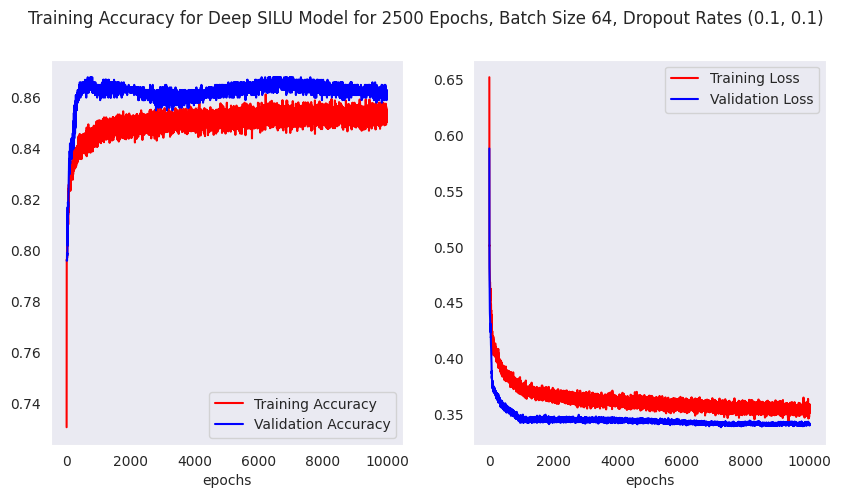

In [ ]:
plot_history(final_model_2_history, 'Deep SILU Model for 2500 Epochs, Batch Size 64, Dropout Rates (0.1, 0.1)')

In [ ]:
import tensorflow as tf

# Save the models.
final_model_1.save("final_model_1.keras")
final_model_2.save("final_model_2.keras")

# Conclusion

This allows us to compare our final results. Let's run the models on the test data.

In [ ]:
# Load the saved model.
loaded_model_1 = tf.keras.models.load_model("final_model_1.keras")
loaded_model_2 = tf.keras.models.load_model("final_model_2.keras")

In [ ]:
print(f'Decision Tree Test Score: {final_tree.score(X_test, y_test):.4f}')
print(f'Random Forest Test Score: {final_forest.score(X_test, y_test):.4f}')
print(f'Neural Network Test Score: {loaded_model_1.evaluate(X_test, y_test)}')
print(f'Neural Network Test Score: {loaded_model_2.evaluate(X_test, y_test)}')

Decision Tree Test Score: 0.8650
Random Forest Test Score: 0.8700
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8596 - loss: 0.3428
Neural Network Test Score: [0.35077956318855286, 0.8510000109672546]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8548 - loss: 0.3514
Neural Network Test Score: [0.36134934425354004, 0.8479999899864197]


In [ ]:
print(f'Decision Tree Precision: {precision_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest Precision: {precision_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 Precision: {precision_score(y_test, np.round(loaded_model_1.predict(X_test))):.4f}')
print(f'Neural Network 2 Precision: {precision_score(y_test, np.round(loaded_model_2.predict(X_test))):.4f}')

Decision Tree Precision: 0.7851
Random Forest Precision: 0.8364
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network 1 Precision: 0.7723
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network 2 Precision: 0.8333


In [ ]:
print(f'Decision Tree Recall: {recall_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest Recall: {recall_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 Recall: {recall_score(y_test, np.round(loaded_model_1.predict(X_test))):.4f}')
print(f'Neural Network 2 Recall: {recall_score(y_test, np.round(loaded_model_2.predict(X_test))):.4f}')

Decision Tree Recall: 0.4657
Random Forest Recall: 0.4510
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 1 Recall: 0.3824
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 2 Recall: 0.3186


In [ ]:
print(f'Decision Tree F-Score: {f1_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest F-Score: {f1_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 F-Score: {f1_score(y_test, np.round(loaded_model_1.predict(X_test))):.4f}')
print(f'Neural Network 2 F-Score: {f1_score(y_test, np.round(loaded_model_2.predict(X_test))):.4f}')

Decision Tree F-Score: 0.5846
Random Forest F-Score: 0.5860
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 1 F-Score: 0.5115
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 2 F-Score: 0.4610


In [ ]:
print(f'Decision Tree ROC-AUC: {roc_auc_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest ROC-AUC: {roc_auc_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 ROC-AUC: {roc_auc_score(y_test, loaded_model_1.predict(X_test)):.4f}')
print(f'Neural Network 2 ROC-AUC: {roc_auc_score(y_test, loaded_model_2.predict(X_test)):.4f}')

Decision Tree ROC-AUC: 0.7165
Random Forest ROC-AUC: 0.7142
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 1 ROC-AUC: 0.8584
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 2 ROC-AUC: 0.8493


## Model Comparison

|Model|Training Score|Validation Score|Test Score|Precision|Recall|F-Score|ROC-AUC|
|-|-|-|-|-|-|-|-|
|Decision Tree Classifier|0.853|0.855|0.865|0.785|0.466|0.585|0.717|
|Random Forest Classifier|0.880|0.866|0.870|0.836|0.451|0.586|0.714|
|Neural Network with ELU|0.850|0.860|0.860|0.772|0.382|0.512|0.858|
|Neural Network with SILU|0.854|0.860|0.855|0.833|0.319|0.461|0.849|

## Final Comments

Given the final results available, there are some remarks to be made on all of them.

- All four have very similar test scores of 0.855-0.870
- The precision for Random Forest and SILU models are noticeably higher at 0.83
- The recall for Decision Tree and Random Forest models are best
- The Random Forest consequently boasts the best F1-Score, marginally beating out the Decision Tree model
- The ELU model has the best ROC-AUC score

Given that the data is imbalanced between churn and not-churn (there are four times as many not-churn customers), it would be more feasible to prioritize the F1 score over the ROC-AUC score. In this instance, identifying a churning customer correctly is highly useful for the business. A customer in danger of churn may be reached out to and offered alternative options to alleviate their financial circumstances or to make the bank more attractive. The cost of reaching out to a customer *not* at risk of churn is quite low - the customer will most likely just ignore the call/email from the bank. Failling to identify a customer at risk of churn can be financially exacting upon the business.

As a result, it would be preferable to have a higher recall (to capture as many at risk of churn) than to have a higher precision. The Decision Tree model has the best recall and boasts a nearly-identical F1 score as the Random Forest. It also has the second-highest test score, beating both of the neural network models.

Therefore the Decision Tree model is our final choice.